## Diffusion equation solution

In [1]:
%reset -f
import numpy as np
from LebedevHelper import *

import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import scipy.sparse as sp
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
import pickle as pkl
import multiprocessing as mp
import time 




In [47]:
%matplotlib inline

# Use latex (must be before use_mathtext:True)
flag_latex=0
if flag_latex:
    # To be able to use SI units as micro (automatically upright)
    params = {'text.usetex':True, 'text.latex.preamble': [r'\usepackage{siunitx}', r'\usepackage{cmbright}',r'\usepackage{mathastext}']}
    mpl.rcParams.update(params)
else:
    mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4  (NOT IF USING TEX)
      


# Set style of plots
ticksize= 16
titlesize = 18
# mpl.style.use('classic')
mpl.rcParams.update({'font.size':ticksize }) 
mpl.rcParams.update({'legend.fontsize':ticksize })# legend
mpl.rcParams.update({'ytick.labelsize':ticksize-2 })
mpl.rcParams.update({'xtick.labelsize':ticksize-2 })
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'axes.labelsize':titlesize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize' :titlesize})
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-3,3]})
mpl.rcParams.update({'figure.figsize':[6,4]})
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams.update({'image.cmap':'rainbow'})
mpl.rcParams.update({'axes.formatter.useoffset':False})   # no offset of axis




# To use unicode
# mpl.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'})
# To get sans-serif
# params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
# plt.rcParams.update(params)

# To get sans-serif
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# mpl.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'})




np.set_printoptions(precision=3,suppress=True) 
plt.close('all')

# 1 - 1D Secure

In [48]:
# xx = [0,1,2,3,4]+[np.inf]
# xc =[0]+[.5,1.5,2.5,3.5] +[4.5,np.inf]

# psic = [.6,.4,.22,.1] + [0]
# dpsi = np.diff(psic)
# dpsi = np.array([dpsi[0]] + list(dpsi)+[0])
# print('xx',xx)
# print(psic)
# print('xc',xc)
# print(dpsi)

# print(next(i for i,v in enumerate(xx) if v > 0)-1)
# print(next(i for i,v in enumerate(xc) if v > 1)-1)
# # print(np.where(xa==4))

## 1.1 - Helper Functions (to be placed elsewhere)

In [49]:
# PySSD
import seaborn as sns
import sys,time
sys.path.append('../')
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
from PySSD.Dispersion import Dispersion
from PySSD.Integrator import FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator

def findQs(detuning, stepSize=5E-5, maxJ=18.0, dJ=0.1, margin=1):
    '''
    '''
    myMin = 1.0
    myMax = 0.0
    for jx in np.arange(0, maxJ, dJ):
        for jy in np.arange(0, maxJ, dJ):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.arange(myMin-margin*stepSize, myMax+margin*stepSize, stepSize)

def get_tune_range(detuning, maxJ=18.0, margin=1e-4, n_samples=100):
    myMin = 1.0
    myMax = 0.0
    for jx in np.linspace(0, maxJ, 100):
        for jy in np.linspace(0, maxJ, 100):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.linspace(myMin - margin, myMax + margin, n_samples)

class MyDistribution1D(Distribution):
    def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0,bool_radial=0):
        self._Jb=Jb.tolist() 
        if bool_radial and 0:
            Jbsq = np.sqrt(Jb)
            self._Jc = Jbsq[1:]*Jbsq[:-1]
        else:
            self._Jc=Jc.tolist()
        self._Psic=Psic.tolist() #+[0]
        self._dPsi=dPsi.tolist() #+[0]
#         self.interp_psi     = sc.interpolate.interp1d(self._Jb,self._Psic,kind='previous')
#         self.interp_dpsidJx = sc.interpolate.interp1d(self._Jc,self._dPsi,kind='previous',bounds_error=False,fill_value="extrapolate")
        kind = ["nearest",'slinear'][0]
        self.interp_psi     = sc.interpolate.interp1d(self._Jc,self._Psic,kind=kind,bounds_error=False,fill_value="extrapolate")
        self.interp_dPsidJx = sc.interpolate.interp1d(self._Jb[1:-1],self._dPsi,kind=kind,bounds_error=False,fill_value="extrapolate")

    def getValue(self, jx, jy):
        return self.interp_psi(jx)*np.exp(-jy)

    def getDJx(self, jx, jy):
        return self.interp_dPsidJx(jx)*np.exp(-jy)

    def getDJy(self, jx, jy):
        return -self.getValue(jx, jy)
    
    
# class MyDistribution1Dy(MyDistribution1D):
#     def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0):
# #         MyDistribution1D.__init__(self,)
#         self._Jb=Jb.tolist() 
#         if bool_radial and 0:
#             Jbsq = np.sqrt(Jb)
#             self._Jc = Jbsq[1:]*Jbsq[:-1]
#         else:
#             self._Jc=Jc.tolist()
#         self._Psic=Psic.tolist() #+[0]
#         self._dPsi=dPsi.tolist() #+[0]
        
# #         self.interp_psi     = sc.interpolate.interp1d(self._Jb,self._Psic,kind=['previous','next'][0])
# #         self.interp_dpsidJy = sc.interpolate.interp1d(self._Jc,self._dPsi,kind=['previous','next'][0])
#         kind = ["nearest",'slinear'][0]
#         self.interp_psi     = sc.interpolate.interp1d(self._Jc,self._Psic,kind=kind,bounds_error=False,fill_value="extrapolate")
#         self.interp_dPsidJy = sc.interpolate.interp1d(self._Jb[1:-1],self._dPsi,kind=kind,bounds_error=False,fill_value="extrapolate")
        
#     def getValue(self, jx, jy):
#         return self.interp_psi(jy)*np.exp(-jx)

#     def getDJx(self, jx, jy):
#         return -self.getValue(jx, jy)
    
#     def getDJy(self, jx, jy):
#         return self.interp_dPsidJy(jy)*np.exp(-jx)
    
class MyDistribution1Dy(MyDistribution1D):
    def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0):
        MyDistribution1D.__init__(self,Jb,Jc,Psic,dPsi)
   
#     def getValue(self, jx, jy):
#         return super().getValue(jy,jx)
    def getDJx(self,jy,jx):
        return super().getDJy(jx,jy)
    def getDJy(self,jy,jx):
        return super().getDJx(jx,jy)
    
#     def getDJy(self, jy, jx):
#         return self.interp_dPsidJx(jx)*np.exp(-jy)

#     def getDJx(self, jy, jx):
#         return -self.getValue(jx, jy)
    
    
    
class MyDistribution2D(Distribution):
    #TODO
    def __init__(self,Jxbx=0,Jxc=0,Jyby=0,Jyc=0,Psic=0,dPsidJx=0,dPsidJy=0,interp_order=0):
        self._Jxbx= Jxbx.copy()
        self._Jyby= Jyby.copy()
        if bool_radial :
            Jxbxsq = np.sqrt(Jxbx)
            self._Jxc = Jxbxsq[1:]*Jxbxsq[:-1]
            Jybysq = np.sqrt(Jyby)
            self._Jyc = Jybysq[1:]*Jybysq[:-1]
        else:
            self._Jxc=Jxc.copy()
            self._Jyc=Jyc.copy()
                
        self._Psic=Psic.copy() 
        self._dPsidJx=dPsidJx.copy()
        self._dPsidJy=dPsidJy.copy()
        
        if interp_order==0:
            temp_interp_psi = sc.interpolate.RegularGridInterpolator((self._Jxc,self._Jyc),self._Psic.T,
                                   method=['nearest','linear'][interp_order],bounds_error=False,fill_value=None)
            self.interp_psi = lambda a,b: temp_interp_psi((a,b))
        else :
            temp_interp_psi = sc.interpolate.RectBivariateSpline(self._Jyc,self._Jxc,self._Psic,
                                                                 kx=interp_order,ky=interp_order)
            self.interp_psi = lambda a,b: temp_interp_psi(a,b,grid=False)
                
        self.interp_dPsidJx = sc.interpolate.RegularGridInterpolator((self._Jxbx[1:-1],self._Jyc),self._dPsidJx.T,
                                   method='nearest',bounds_error=False,fill_value=None)
        self.interp_dPsidJy = sc.interpolate.RegularGridInterpolator((self._Jxc,self._Jyby[1:-1]),self._dPsidJy.T,
                                   method='nearest',bounds_error=False,fill_value=None)

    def getValue(self, jx, jy=0):
        return self.interp_psi(jx,jy)

    def getDJx(self, jx, jy=0):
        return self.interp_dPsidJx((jx,jy))

    def getDJy(self, jx, jy=0):
        return self.interp_dPsidJy((jx,jy))

class MyDistribution2Dy(MyDistribution2D):
    def __init__(self,Jxbx=0,Jxc=0,Jyby=0,Jyc=0,Psic=0,dPsidJx=0,dPsidJy=0,interp_order=0):
        MyDistribution2D.__init__(self,Jyby,Jyc,Jxbx,Jxc,Psic.T,dPsidJy.T,dPsidJx.T,interp_order=0)
        return

In [50]:

# Post setup functions
def DiffCoeff1(X,D_ibs,D_k):
    # X is the main coordinate (r, J)
    return X*(D_ibs + D_k)
def DiffCoeff2(X,D_ibs,D_k,dQ,dQAvg,g):
    # X is the main coordinate (r, J)
    g2 = g/2
    dmu = 2*np.pi*(dQ-dQAvg)
    return X*(D_ibs + D_k * LL(g2,dmu))


def DiffCoeff(Mach,Grid,iCoeff):
    # Noise: Mach.N
    # Detuning: Mach.Q
    DDx = np.zeros_like(Grid.Jxbx2D)
    DDy = np.zeros_like(Grid.Jyby2D)
    if iCoeff ==1:
        DDx = DiffCoeff1(Grid.X,Mach.N.D_ibsx,Mach.N.D_kx)
        if Grid.ND==2:
            DDy = DiffCoeff1(Grid.Y,Mach.N.D_ibsy,Mach.N.D_ky)
    elif iCoeff ==2:
        DDx = DiffCoeff2(Grid.X, Mach.N.D_ibsx, Mach.N.D_kx,
                            Mach.Q.dQx(Grid.Jxbx2D,Grid.Jybx2D), Mach.N.dQxAvg, Mach.gx)
        if Grid.ND==2:
            DDy = DiffCoeff2(Grid.Y, Mach.N.D_ibsy, Mach.N.D_ky,
                            Mach.Q.dQy(Grid.Jxby2D,Grid.Jyby2D), Mach.N.dQyAvg, Mach.gy)
    return DDx, DDy
    
def DiffCoeffX(Mach,X,JX,JY,iCoeff):
    # Noise: Mach.N
    # Detuning: Mach.Q
    DDx = 0 #np.zeros_like(JX)
    if iCoeff ==1:
        DDx = DiffCoeff1(X,Mach.N.D_ibsx,Mach.N.D_kx)
    elif iCoeff ==2:
        DDx = DiffCoeff2(X,Mach.N.D_ibsx,Mach.N.D_kx,
                        Mach.Q.dQx(JX,JY),Mach.N.dQxAvg,Mach.gx)
    return DDx


# Drift coeffeicient
def DriftCoeff2(Jb,D_k,alpha,dQ,dQAvg,dQdJ,g):
    g2 = g/2
    dmu = 2*np.pi*(dQ-dQAvg)        
    return -Jb*((1-alpha)*D_k * dLLdm(g2,dmu) * pi2*dQdJ)
def DriftCoeff(Mach,Grid,iCoeff):
    # Noise: Mach.N
    # Detuning: Mach.Q  
    Ux = np.zeros_like(Grid.Jxbx2D)
    Uy = np.zeros_like(Grid.Jyby2D)
    
    if iCoeff==1:
        None
    elif iCoeff ==2:
        if Mach.N.alpha!=1: 
            Ux = DriftCoeff2(Grid.Jxbx2D,Mach.N.D_kx,Mach.N.alpha,
                             Mach.Q.dQx(Grid.Jxbx2D,Grid.Jybx2D),Mach.N.dQxAvg,Mach.Q.dQxdJx(Grid.Jxbx2D,Grid.Jybx2D),Mach.gx)
            if Grid.ND==2:
                Uy = DriftCoeff2(Grid.Jyby2D,Mach.N.D_ky,Mach.N.alpha,
                             Mach.Q.dQy(Grid.Jxby2D,Grid.Jyby2D),Mach.N.dQxAvg,Mach.Q.dQydJy(Grid.Jxby2D,Grid.Jyby2D),Mach.gy)
    return Ux,Uy



###############################################################################################
# Numerical integration
def trapezoidal(x,y,bool_FVM=0):
    if bool_FVM:
        dx = np.diff(x)[0]
        return np.sum(np.diff(x)*y)
    else:
        return np.sum(np.diff(x)*(y[1:]+y[:-1]))*0.5
    


########################   
## Plotting functions ##
def func_moments(xb,xc,psis,ts,bool_radial,bool_FVM):
    # store moments
    moments = np.zeros((ts.size,4))
    for i , t in enumerate(ts):
        if bool_radial:
            moments[i,:] = [trapezoidal(xb,xc*psis[i,:]*xc**j ,bool_FVM) for j in [0,1,2,3]]
        else:
            moments[i,:] = [trapezoidal(xb,   psis[i,:]*xc**j ,bool_FVM) for j in [0,1,2,3]]
    return moments


def plot_psis_1D(x,psis,ts,i_coordType,yscale='linear',D=0,sig0=1,plot_sep=1,bool_theory_g0=1,xmax=6,lw=1,ls='-',
                fignradd=0,bool_fill=0):
    # Set colorbar as time measurement:
    norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    cmap.set_array([])
    
    #Fix distribution
    need_fix=0
    if np.min(x)>0 and 1:
        need_fix=1
        x_orig = x
        x = np.concatenate(([0],x_orig))
        psis_orig = psis
        psis = np.zeros((np.size(ts),np.size(x)))
        
    
    # Initiate plots
    fig1, ax1 = plt.subplots(num=30+2*i_coordType+fignradd)
    fig2, ax2 = plt.subplots(num=31+2*i_coordType+fignradd)
    
    for i , t in enumerate(ts):  
        
        if i%plot_sep==0:
            if need_fix:
                func = sc.interpolate.interp1d(x_orig,psis_orig[i,:],kind='linear',bounds_error=False,fill_value='extrapolate')#(0,0))
                psis[i] = func(x)
    
            if not bool_fill:
                ax1.plot(x, psis[i,:], c=cmap.to_rgba(t/time_scale),lw=lw,ls=ls)
            else:
                if t==ts[0]: continue
                ax1.fill_between(x, psis[i,:],psis[i-plot_sep,:], color=cmap.to_rgba(t/time_scale))
            ax2.plot(x,(psis[i,:]-psis[0,:])/1+0*psis[0,:], c=cmap.to_rgba(t/time_scale),lw=lw,ls=ls)

    # Theoretical curve
    if bool_theory_g0:
        tmax = np.max(ts)
        sig2t = sig0**2 + D*tmax
        if i_coordType==0:
            psitheory = 1/sig2t*np.exp(-x/sig2t)
        elif i_coordType==1:
            psitheory = 1/sig2t*np.exp(-0.5*x**2/sig2t)
        elif i_coordType==2:
            psitheory = 1/np.sqrt(2*np.pi*sig2t)*np.exp(-.5*x**2/sig2t)
        
        ax1.plot(x,psitheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
    
    # Fix layout of plots
    for ax in [ax1,ax2]:
        #         ax.legend(loc=0)
        ax.set_xlabel([r'$J$',r'$r$',r'$x$'][i_coordType],labelpad=[-1,-1,-1][i_coordType])
        ax.set_xlim([[0,.5*xmax**2],[0,xmax],[-xmax,xmax]][i_coordType])
        ax.grid(True)
        
    ax1.set_ylabel(r'$\Psi$') 
    ax1.set_yscale(yscale)
    ax2.set_ylabel(r'$\Psi(t)-\Psi(0)$')
#     ax2.set_ylim([-1,1])
    
    for fig in [fig1,fig2]:
        cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
        tick_locator = mpl.ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        fig.tight_layout()

    return fig1,ax1,fig2,ax2

In [65]:
class DetuningClass(object):
#     @abstractmethod
    def __init__(self,*args):
        pass
    def dQx(self,Jx,Jy):
        pass
    def dQy(self,Jx,Jy):
        pass
    def dQxdJx(self,Jx,Jy):
        pass
    def dQxdJy(self,Jx,Jy):
        pass
    def dQydJx(self,Jx,Jy):
        pass
    def dQydJy(self,Jx,Jy):
        pass
class LinearDetuningClass(DetuningClass):
    def __init__(self,Q0x,Q0y,ax,bx,ay,by):
        self.Q0x = Q0x
        self.Q0y = Q0y
        self.ax = ax
        self.bx = bx
        self.ay = ay
        self.by = by
    def dQx(self,Jx,Jy):
        return self.ax*Jx + self.bx*Jy
    def dQy(self,Jx,Jy):
        return self.by*Jx + self.ay*Jy
    def dQxdJx(self,Jx,Jy):
        return self.ax
    def dQxdJy(self,Jx,Jy):
        return self.bx
    def dQydJx(self,Jx,Jy):
        return self.by
    def dQydJy(self,Jx,Jy):
        return self.ay
    
class NoiseClass(object):
    def __init__(self,f_rev, sigma_kx,dQxAvg,sigma_ky,dQyAvg,alpha,
                             sigma_ibsx,sigma_ibsy,
                             A_hx,dQ_hx,A_hy,dQ_hy):
        # White noise (Lebedev)
        self.sigma_kx = sigma_kx
        self.sigma_ky = sigma_ky
        self.dQxAvg = dQxAvg
        self.dQyAvg = dQyAvg
        self.alpha  = alpha
        self.D_kx = f_rev*self.sigma_kx**2/2
        self.D_ky = f_rev*self.sigma_ky**2/2
        # IBS, incoherent noise
        self.sigma_ibsx = sigma_ibsx
        self.sigma_ibsy = sigma_ibsy
        self.D_ibsx = f_rev*sigma_ibsx**2/2
        self.D_ibsy = f_rev*sigma_ibsy**2/2
        # Harmonic excitation
        self.A_hx  = A_hx
        self.dQ_hx = dQ_hx
        self.A_hy  = A_hy
        self.dQ_hy = dQ_hy
    
        
class MachineClass(object):
    def __init__(self,detuning,noise,g=0,f_rev = 11245):
        self.Q = detuning
        self.N = noise
        
        self.gx = g
        self.gy = g
        self.f_rev = f_rev
        
class GridClass(object):
    def __init__(self, Ncx,JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,
                       Ncy,JyMax,JyAvg,BC_yMax,BC_yVal):
        self.Ncx = Ncx  ;  self.Nbx = Ncx+1
        self.Ncy = Ncy  ;  self.Nby = Ncy+1
        self.NcTot= self.Ncx * self.Ncy
        
        self.ncol = Ncx
        self.nrow = Ncy
        if self.Ncy ==1:
            JyMax=1
        
        self.JxAvg = JxAvg  ;  self.rxAvg = np.sqrt(2*JxAvg)
        self.JxMax = JxMax  ;  self.rxMax = np.sqrt(2*JxMax)
        self.JyAvg = JyAvg  ;  self.ryAvg = np.sqrt(2*JyAvg)
        self.JyMax = JyMax  ;  self.ryMax = np.sqrt(2*JyMax)
        
        self.bool_radial = bool_radial
        if bool_radial:
            self.hx = self.rxMax/Ncx
            self.rxbx = np.linspace(0,self.rxMax,self.Nbx)
            self.Jxbx= .5*self.rxbx**2
            self.hy = self.ryMax/Ncy
            self.ryby = np.linspace(0,self.ryMax,self.Nby)
            self.Jyby = .5*self.ryby**2
            
            #Temp
            self.rxc = (self.rxbx[1:]+self.rxbx[:-1])*.5
            self.ryc = (self.ryby[1:]+self.ryby[:-1])*.5
            self.Jxc = .5*self.rxc**2
            self.Jyc = .5*self.ryc**2
        else:
            self.hx = JxMax/Ncx
            self.Jxbx= np.linspace(0,self.JxMax,self.Nbx)
            self.rxbx = np.sqrt(2*self.Jxbx)
            self.hy = JyMax/Ncy
            self.Jyby = np.linspace(0,self.JyMax,self.Nby)
            self.ryby = np.sqrt(2*self.Jyby)
                
            #Temp
            self.Jxc = (self.Jxbx[1:]+self.Jxbx[:-1])*.5
            self.Jyc = (self.Jyby[1:]+self.Jyby[:-1])*.5
            self.rxc = np.sqrt(self.Jxc*2)
            self.ryc = np.sqrt(self.Jyc*2)
            
        self.rxc = (self.rxbx[1:]+self.rxbx[:-1])*.5
        self.ryc = (self.ryby[1:]+self.ryby[:-1])*.5
        self.Jxc = (self.Jxbx[1:]+self.Jxbx[:-1])*.5
        self.Jyc = (self.Jyby[1:]+self.Jyby[:-1])*.5
        
       
        # Get meshed grids of boundary face points
        self.Jxbx2D , self.Jybx2D = np.meshgrid(self.Jxbx,self.Jyc)
        self.Jxby2D , self.Jyby2D = np.meshgrid(self.Jxc,self.Jyby)
        self.rxbx2D , self.rybx2D = np.meshgrid(self.rxbx,self.ryc)
        self.rxby2D , self.ryby2D = np.meshgrid(self.rxc,self.ryby)
        self.X = [self.Jxbx2D,self.rxbx2D][bool_radial]  
        self.Y = [self.Jyby2D,self.ryby2D][bool_radial]
        
        # Get meshed grids of center-of-cell points
        self.Jxc2D, self.Jyc2D = np.meshgrid(self.Jxc,self.Jyc)
        self.Jxc1D = self.Jxc2D.flatten()  ;  self.Jyc1D = self.Jyc2D.flatten()
        self.rxc2D, self.ryc2D = np.meshgrid(self.rxc,self.ryc)
        self.rxc1D = self.rxc2D.flatten()  ;  self.ryc1D = self.ryc2D.flatten()
        
        # Get meshed grids of corner/node points
        self.Jxn2D, self.Jyn2D = np.meshgrid(self.Jxbx,self.Jyby)
        self.rxn2D, self.ryn2D = np.meshgrid(self.rxbx,self.ryby)       
        
        
        # Create slices
        self.sliceN = [slice(1,None,1),slice(0,None,1)]
        self.sliceS = [slice(0,-1,1),slice(0,None,1)]
        self.sliceE = [slice(0,None,1),slice(1,None,1)]
        self.sliceW = [slice(0,None,1),slice(0,-1,1)]
        
        # Boundary conditions
        self.BC_xMax = BC_xMax
        self.BC_xVal = BC_xVal
        self.BC_yMax = BC_yMax
        self.BC_yVal = BC_yVal
        
        
        
    def get_rx(self):
        return self.rxbx,self.rxc
    def get_Jx(self):
        return self.Jxbx,self.Jxc
    def get_Mavgx(self):
        return self.MavgW,self.MavgE
    def get_Mslpx(self):
        return self.MslpW,self.MslpE
    def get_ry(self):
        return self.ryby,self.ryc
    def get_Jy(self):
        return self.Jyby,self.Jyc
    def get_Mavgy(self):
        return self.MavgS,self.MavgN
    def get_Mslpy(self):
        return self.MslpS,self.MslpN



class Grid1DClass(GridClass):
    def __init__(self, Ncx, JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,bool_adjustGrid):
        if bool_adjustGrid:
            # Recaclculate the grid points
            if bool_radial:     
                rxAvg = np.sqrt(2*JxAvg)
                hx = np.sqrt(2*JxMax)/Ncx
                hx = (rxAvg)/np.floor(rxAvg/hx)   # adjust so that boundary is at rxAvg
                rxMax0= np.sqrt(2*JxMax)
                print('Change of h from %.3f to %.3f - rMax from %.3f to %.3f'%(
                        rxMax0/Ncx,hx,rxMax0,hx*Ncx))
                rxMax = hx*Ncx
                JxMax = .5*rxMax**2
            else: # bool_radial == False
                hx = JxMax/Ncx
                hx = (JxAvg)/np.floor(JxAvg/hx)   # adjust so that boundary is at JxAvg
                JxMax = hx*Ncx
                print('Change of h from %.3f to %.3f - JxMax from %.3f to %.3f'%(
                        JxMax/Ncx,hx,JxMax,hx*Ncx))
                
        GridClass.__init__(self, Ncx, JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,
                                 1  , 0    , 0   ,0      ,0      )
        self.ND = 1 # 1D grid
                   
        ## Create Stencil Matrices with BC
        self._SpStencilMatrices()
        self._BC()
            
    def _SpStencilMatrices(self):
        print('stencil 1D')
        Nc = self.NcTot
        hx = self.hx
        
        self.MavgW = sp.diags([0.5,0.5] ,[0,-1],shape=(Nc,Nc),format='csr')/(hx)
        self.MavgE = sp.diags([0.5,0.5] ,[0,1 ],shape=(Nc,Nc),format='csr')/(hx)
        self.MslpW = sp.diags([-1,1]    ,[-1,0],shape=(Nc,Nc),format='csr')/(hx*hx)
        self.MslpE = sp.diags([-1,1]    ,[0,1 ],shape=(Nc,Nc),format='csr')/(hx*hx)
        if self.bool_radial:
            #Multiply each row with element: sparse.multiply(numpy[:,np.newaxis])
            #Multiply each col with element: sparse.multiply(numpy)   (faster than making new diag)
            rcinv = 1/self.rxc[:,np.newaxis]
            self.MavgW = self.MavgW.multiply(rcinv).tocsr()    #keep J = .5r^2 in U
            self.MavgE = self.MavgE.multiply(rcinv).tocsr() 
            self.MslpW = self.MslpW.multiply(rcinv/2).tocsr()
            self.MslpE = self.MslpE.multiply(rcinv/2).tocsr() 
            # /2 because D(J) ->D(r)/2
            
    
    def _BC(self):
        print('BC 1D')
        # Mandatory reflective boundary at r=0
        self.MslpW[0,0]=0
        self.MavgW[0,0]=0

        #Vector for nonhomogeneous BC
        self.boundary_E =np.zeros(self.NcTot)
        self.boundary_E[-1]=1 
        
        # BC at xmax
        if  self.BC_xMax==0:
            # Absorbing Dirichlet Psi=0
            None
        elif self.BC_xMax==1:
            # Reflective boundary at r=rMax
            self.MslpE[-1,-1]=0
            self.MavgE[-1,-1]*=2
#             self.boundary_E *= self.hx # Already in calc_BC_V
        elif self.BC_xMax==2:
            # Robin condition, not yet perfect
            if self.bool_radial:
                self.MslpE[-1,-1]*=   self.hx*self.rxc[-1]
                self.MavgE[-1,-1]*=(2-self.hx*self.rxc[-1])
            else:
                self.MslpE[-1,-1]*=   self.hx
                self.MavgE[-1,-1]*=(2-self.hx)
        elif self.BC_xMax==3:
            # dJPsi_N = dJPsi_N+1
            self.MslpE[-1,-2]=self.MslpE[-1,-1]
            self.MslpE[-1,-1]*=(-1)
            self.MavgE[-1,-2]=-self.MavgE[-1,-1]
            self.MavgE[-1,-1]*=3
        else:
            print('OBS Not implemented BC_xMax > 3!')
    
class Grid2DClass(GridClass):
    def __init__(self, Ncx,  JxMax,  JxAvg,  BC_xMax,  BC_xVal,bool_radial,
                       Ncy=1,JyMax=0,JyAvg=0,BC_yMax=0,BC_yVal=0):
        self.ND = 2
        if Ncy==1:
            # Assume always fill up vertical 
            self.ND = 1
        GridClass.__init__(self, Ncx,JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,
                       Ncy,JyMax,JyAvg,BC_yMax,BC_yVal)
    
            
        # If 2D
        self._SpStencilMatrices()
        self._BC()
        
    def _SpStencilMatrices(self):
        print('stencil 2D')
        Nc = self.NcTot
        col= self.ncol
        hx = self.hx
        hy = self.hy
        
        one0 = np.ones(Nc)
        one1 = np.ones(Nc-1) ; one1[col-1::col]=0
        
        # Create stencil matrices
        self.MavgW = sp.diags([one0,one1] ,[0,-1],shape=(Nc,Nc),format='csr')/(2*hx)
        self.MavgE = sp.diags([one0,one1] ,[0,1 ],shape=(Nc,Nc),format='csr')/(2*hx)
        self.MslpW = sp.diags([-one1,one0],[-1,0],shape=(Nc,Nc),format='csr')/(hx*hx)
        self.MslpE = sp.diags([-one0,one1],[0,1 ],shape=(Nc,Nc),format='csr')/(hx*hx)
        
        if self.ND ==2:
            self.MavgS = sp.diags([1,1]       ,[0,-col],shape=(Nc,Nc),format='csr')/(2*hy)
            self.MavgN = sp.diags([1,1]       ,[0,col] ,shape=(Nc,Nc),format='csr')/(2*hy)
            self.MslpS = sp.diags([-1,1]      ,[-col,0],shape=(Nc,Nc),format='csr')/(hy*hy)
            self.MslpN = sp.diags([-1,1]      ,[0,col] ,shape=(Nc,Nc),format='csr')/(hy*hy)
        
        # Update if radial coordinates
        if self.bool_radial:
            rxcinv = 1/self.rxc1D[:,np.newaxis]
            self.MavgW = self.MavgW.multiply(rxcinv).tocsr()
            self.MavgE = self.MavgE.multiply(rxcinv).tocsr()
            self.MslpW = self.MslpW.multiply(rxcinv/2).tocsr()
            self.MslpE = self.MslpE.multiply(rxcinv/2).tocsr()
            
            if self.ND ==2:
                rycinv = 1/self.ryc1D[:,np.newaxis]
                self.MavgS = self.MavgS.multiply(rycinv).tocsr()
                self.MavgN = self.MavgN.multiply(rycinv).tocsr()
                self.MslpS = self.MslpS.multiply(rycinv/2).tocsr()
                self.MslpN = self.MslpN.multiply(rycinv/2).tocsr()
            
        
    def _BC(self):
        print('BC 2D')
        col = self.ncol
        row = self.nrow
        Nelm= self.NcTot
        elmBE = np.arange(col-1,Nelm,col)
        elmBW = np.arange(0,Nelm,col)
        elmBS = np.arange(0,col,1)
        elmBN = np.arange((row-1)*col,Nelm,1)
        
        # Mandatory reflective boundary at r=0
        self.MslpW[elmBW,elmBW]=0
        self.MavgW[elmBW,elmBW]=0
                   
        #Vector for nonhomogeneous BC
        self.boundary_E =np.zeros(self.NcTot)
        self.boundary_E[elmBE]=1
                
        # BC at xmax
        if  self.BC_xMax==0:
            # Absorbing Dirichlet Psi=0
            None
        elif self.BC_xMax==1:
            # Reflective boundary at r=rMax
            self.MslpE[elmBE,elmBE]=0
            self.MavgE[elmBE,elmBE]*=2
        elif self.BC_xMax>1:
            print("Havent implemented BC in Grid2DClass for iBC>1")
            
        # In Vertical:
        if self.ND ==2:
            # Mandatory reflective boundary at r=0
            self.MslpS[elmBS,elmBS]=0
            self.MavgS[elmBS,elmBS]=0
            
            #Vector for nonhomogeneous BC
            self.boundary_N =np.zeros(self.NcTot)
            self.boundary_N[elmBN]=1
            
            # BC at ymax
            if  self.BC_yMax==0:
                # Absorbing Dirichlet Psi=0
                None
            elif self.BC_yMax==1:
                # Reflective boundary at r=rMax
                self.MslpN[elmBN,elmBN]=0
                self.MavgN[elmBN,elmBN]*=2
            elif self.BC_yMax>1:
                print("Havent implemented BC in Grid2DClass for iBC>1")


class SolverClass(object):
    def __init__(self,machine,grid,iCoeff=2):
        self.M = machine
        self.G = grid
        
        self.ND = self.G.ND
        self.iCoeff=iCoeff
        
        self.calc_Coeff()
        self.calc_FV_M()
        self.calc_BC_V()
        
        #Calculation
        self._IC()
        
    
    def calc_Coeff(self):
        Diffx,Diffy = DiffCoeff(self.M,self.G,self.iCoeff)
        Driftx,Drifty = DriftCoeff(self.M,self.G,self.iCoeff)
        
        self.DiffE  = np.reshape(Diffx[self.G.sliceE], (self.G.NcTot,1))
        self.DiffW  = np.reshape(Diffx[self.G.sliceW], (self.G.NcTot,1))
        self.DriftE = np.reshape(Driftx[self.G.sliceE], (self.G.NcTot,1))
        self.DriftW = np.reshape(Driftx[self.G.sliceW], (self.G.NcTot,1))
        
        if self.ND >1:
            print(Diffy.shape)
            self.DiffN  = np.reshape(Diffy[self.G.sliceN], (self.G.NcTot,1))
            self.DiffS  = np.reshape(Diffy[self.G.sliceS], (self.G.NcTot,1))
            self.DriftN = np.reshape(Drifty[self.G.sliceN], (self.G.NcTot,1))
            self.DriftS = np.reshape(Drifty[self.G.sliceS], (self.G.NcTot,1))
        return
    
    def calc_FV_M(self):
        self.FV_M= ((self.G.MslpE.multiply(self.DiffE) - self.G.MslpW.multiply(self.DiffW))- 
                    (self.G.MavgE.multiply(self.DriftE) - self.G.MavgW.multiply(self.DriftW)))
        if self.ND==2:
            self.FV_M += ((self.G.MslpN.multiply(self.DiffN)  - self.G.MslpS.multiply(self.DiffS))- 
                          (self.G.MavgN.multiply(self.DriftN) - self.G.MavgS.multiply(self.DriftS)))
        return
    
    def _calc_BC_V_1D(self,iBC,K,h,boundary,Diff,Drift,rc):
        if K==0:
            print("Homogeneous BC")
            return 0
        
        #Create Diff and Drift vectors including matrices
        V_Diff = Diff/h**2
        V_Drift= Drift/(2*h)
        if self.G.bool_radial:
            V_Diff /= (2*rc)
            V_Drift/= (rc)
        
        # Return the values
        if   iBC==0:
            return K*boundary * (V_Diff - V_Drift) #+vertical part
        elif iBC==1:
            return K*boundary * (V_Diff - V_Drift)*h    #+vertical part
        elif iBC>1:
            print("Havent implemented nonhomogneeous BC for BC_xMax>1")
            return 0
    def calc_BC_V(self):
        self.BC_V = 0 
        #Boundary at xmax
        if self.ND==1:
            self.BC_V += self._calc_BC_V_1D(self.G.BC_xMax,self.G.BC_xVal, self.G.hx,
                                       self.G.boundary_E,self.DiffE[:,0],self.DriftE[:,0],self.G.rxc[-1])
        elif self.ND==2:
            self.BC_V += self._calc_BC_V_1D(self.G.BC_xMax,self.G.BC_xVal, self.G.hx,
                                       self.G.boundary_E,self.DiffE[:,0],self.DriftE[:,0],self.G.rxc[-1])
            self.BC_V += self._calc_BC_V_1D(self.G.BC_yMax,self.G.BC_yVal, self.G.hy,
                                       self.G.boundary_N,self.DiffN[:,0],self.DriftN[:,0],self.G.ryc[-1])

    ########################
    ## Initial conditions ##
    def _IC(self):
        sigx0 = 1
        bool_point = 0
        self.G.Jxbx2D[self.G.sliceE]
        if bool_point: self.psi0 =    (1/sigx0**2*np.exp(-[self.G.Jxc1D,.5*self.G.rxc1D**2][self.G.bool_radial]/(sigx0**2)))
        else:          self.psi0 =    (np.exp(-self.G.Jxbx2D[self.G.sliceW]/sigx0**2)-np.exp(-self.G.Jxbx2D[self.G.sliceE]/sigx0**2))/np.diff(self.G.Jxbx2D,axis=1)
        if self.ND==2:
            sigy0 = 1
            if bool_point: self.psi0 *=1/sigy0**2*np.exp(-[self.G.Jyc1D,.5*self.G.ryc1D**2][self.G.bool_radial]/(sigy0**2))
            else:          self.psi0 *= (np.exp(-self.G.Jyby2D[self.G.sliceS]/sigy0**2)-np.exp(-self.G.Jyby2D[self.G.sliceN]/sigy0**2))/np.diff(self.G.Jyby2D,axis=0)
        self.psi0 = self.psi0.flatten()
        return
    def set_IC(self,psi0):
        self.psi0 = psi0
        return
    
    ###################
    ## Solve the PDE ##
    def dpsidtFV_const(self,t,psi):
        return self.FV_M.dot(psi) + self.BC_V

    def dpsidtFV_tdep(self,t,psi):
        # Not relevant time dependence...
        self.M.N.dQxAvg = self.M.Q.dQx(1+3*t/tmax,0)
        self.calc_Coeff()
        self.calc_FV_M()
        self.calc_BC_V()
        return self.FV_M.dot(psi) + self.BC_V
    
    def solve(self, tsODE, i_dpsidt=0, solve_method = 'BDF'):
        self.tsODE = tsODE
        self.tmax = np.max(tsODE)
        
        if i_dpsidt==0:
            dpsidt=lambda t, y: self.dpsidtFV_const(t, y)
        elif i_dpsidt==1:
            dpsidt=lambda t, y: self.dpsidtFV_tdep(t,y)
            
        solution = sc.integrate.solve_ivp(dpsidt, t_span=[0,self.tmax],y0=self.psi0,t_eval=self.tsODE,
                                          method=solve_method)
        
        self.ts = solution.t
        if not np.all(self.ts==self.tsODE):
            print('ERROR: Not same input and output times. Biggest offset is %.0e'%(
                    np.max(np.abs(self.tsODE-self.ts))))
        self.psis=solution.y.T
        
        return self.psis
            
        #                                   method='RK45',max_step=dtmax)             

In [66]:
grid1 = Grid1DClass(Ncx=3,JxMax=3,JxAvg=1,BC_xMax=1,BC_xVal=0,bool_radial=1,bool_adjustGrid=0)
grid2 = Grid2DClass(Ncx=3,JxMax=3,JxAvg=1,BC_xMax=1,BC_xVal=0,bool_radial=1,
                    Ncy=2,JyMax=2,JyAvg=1,BC_yMax=1,BC_yVal=0)


for grid in [grid1,grid2]:
    MslpW,MslpE = grid.get_Mslpx()
    print(MslpW.toarray())
    print(MslpE.toarray())
print('Mavgx')
for grid in [grid1,grid2]:
    v1,v2 = grid.get_Mavgx()
    print(v1.toarray())
    print(v2.toarray())
print('Mslpx')
for grid in [grid1,grid2]:
    v1,v2 = grid.get_Mslpx()
    print(v1.toarray())
    print(v2.toarray())
print('Mslpy', 'Mavgy')
for v in [grid2.get_Mslpy(),grid2.get_Mavgy()]:
    v1,v2 = v
    print(v1.toarray())
    print(v2.toarray())
    
    

stencil 1D
BC 1D
stencil 2D
BC 2D
[[ 0.     0.     0.   ]
 [-0.612  0.612  0.   ]
 [ 0.    -0.367  0.367]]
[[-1.837  1.837  0.   ]
 [ 0.    -0.612  0.612]
 [ 0.     0.     0.   ]]
[[ 0.     0.     0.     0.     0.     0.   ]
 [-0.612  0.612  0.     0.     0.     0.   ]
 [ 0.    -0.367  0.367  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.612  0.612  0.   ]
 [ 0.     0.     0.     0.    -0.367  0.367]]
[[-1.837  1.837  0.     0.     0.     0.   ]
 [ 0.    -0.612  0.612  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -1.837  1.837  0.   ]
 [ 0.     0.     0.     0.    -0.612  0.612]
 [ 0.     0.     0.     0.     0.     0.   ]]
Mavgx
[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.  0.3 0.3]]
[[1.5 1.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  0.6]]
[[0.  0.  0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0.  0. ]
 [0.  0.3 0.3 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.3 0.3]]
[[1.5 1.5 0.  0. 

Goal: Generalize functions to simplify transfer: 1D -> 2D, Ioct ->BB, Leb->Other noises  
Things to do:  

* **include machine parameters in the classes defined above**  
* **Create Grid1DClass**
* **Create function that returns rb,rc,Jb,Jc**
* **Create function that returns Matrices for Mean and Diff INCLUDING BC**
* **update:  DiffCoeff, DriftCoeff**  
  * **to use the classes in point 1**  
  * ~~to include the factor 1/2 when bool_radial is True~~
    * **REMOVED FROM D0  -> ADDED TO STENCILMATRICES**
  * ~~should calculate D0, Dibs, Dhmax themselves?~~  
    * **Done in NoiseClass**  
* **Consider using sparse matrices  
  import scipy.sparse as sp**
* **Change from L, R, U, D -> W, E, N, S  (west, etc.)  **
* FVM in 2D is problematic - for a cell center (xi,yj)  
  need edges at (xi+-.5,yj) for horizontal diffusion  
  need edges at (xi,yj+-.5) for vertical diffusion   - not original (xi+-.5, yj+-.5)  
  * **Create Grid2DClass**
  * **Implement stencil matrices also in radial**
  * **Implement BC also in radial**
  * Implement more than 2 BC
  * Make a good psi(rx,ry) -> psi(rx)
  * Fix psi(rx,ry) -> psi(Jx,Jy) (in 2D)
  * Make plotting functions for 2D
* Clean up 1D solver
  * Clean the "psi(r)/psi(J) -> psi(x)
  * Clean the plotting situation
* **Implement the "dpsidt" in SolverClass**
* Improve Stability Diagram part
  * create interpolation function for psi2D
  * clean up the functions etc.
  * make it possible to calculate stability threshold for certain distribution (and evolution over time)

## 1.2 - Actual Numerical Calculation

In [86]:
#################################
## Beam and Machine parameters ##
f_LHC = 11.245e3
Qx =0.31
Qy =0.32
a=1.64e-4  
a = 1e-4
b=-a *190/260
g=0.02

# Noise parameters
sigma_k = 1e-4
sigma_k = 1e-3 /np.sqrt(3) 
# sigma_k = 1e-3
JAvg = 1
dQAvg = a*JAvg
D0  = sigma_k**2*f_LHC / (2 )#+ 2*bool_radial) # need a second '/2' if operating with r
sigma_ibs= 0
Dibs= sigma_ibs**2*f_LHC / (2 )#+ 2*bool_radial) # need a second '/2' if operating with r
Ah     = 0  # Harmonic excitation noise  #temp for harmonic excitation
Jh     = 1
dQh    = a*Jh
# Dmax
# wJ


######################################
####### Calculation parameters #######
alpha= 1              # alpha = 0: direct from Lebedev, alpha=1: cancel drift term
iCoeff  = 2           # Which diffusion coefficient [0, constant (r), K*LL (r),...,10,constant (J),K*LL(J)]
bool_FVM = 1          # true: use FVM, false: use FDM  (only implemented FVM)
bool_radial = 0       # true: radial PDE, false: action PDE
bool_adjustGrid = 1   # true: shift grid so that one cell is centered on the zero
BC_xMax = 0           # i = [Dirichlet Psi=0, Neumann djPsi=0, Robin: djPsi+Psi=0 or drPsi+rPsi=0, dPsi const]
BC_xVal = 0

# Time Iteration Parameters
# nturns = f_LHC * 3600 * 24
nturns = [37.5e6,100e6][alpha]     # 100e6 for comparison to COMBIp, 37.5 for comparison to easy incoherent noise
nturns = 100e6
# nturns = 2e4
tmax = nturns/f_LHC
# nt=int(nturns/5e5)+1
nt = 14
# nt = 4
tsODE = np.linspace(0,tmax,nt)


# Define grid 
ND = 1
Nc = 380
Nb = Nc+1
rMax = 6         ; rAvg = np.sqrt(2*JAvg) 
JMax = rMax**2/2 ; JAvg = JAvg              #See noise parameters

##########################################
## Store parameters in relevant objects ##

detuning = LinearDetuningClass(Qx,Qy
                          ,a,b,a,b)
noise = NoiseClass(f_LHC,sigma_k,dQAvg,sigma_k*0,dQAvg,alpha,
                         sigma_ibs,0,
                         Ah,dQh,0,-1)
mach = MachineClass(detuning,noise,g,f_LHC)
# grid = Grid1DClass(Nc,JMax,JAvg,BC_xMax,BC_xVal,bool_radial,bool_adjustGrid)
if ND ==1:
    grid = Grid2DClass(Nc,JMax,JAvg,BC_xMax,BC_xVal,bool_radial)
else:
    grid = Grid2DClass(Nc,JMax,JAvg,BC_xMax,BC_xVal,bool_radial,
                   Nc,JMax,JAvg,BC_xMax,BC_xVal)
calc = SolverClass(mach,grid,iCoeff)


###########################
## Solve PDE numerically ##
start = time.time()

psis = calc.solve(tsODE)

tot = time.time()-start
print('it took %.2fs'%(tot))

stencil 2D
BC 2D
Homogeneous BC
it took 0.04s


[0.011374235153198242]


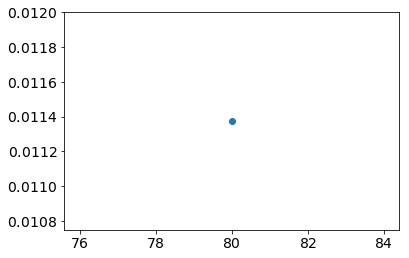

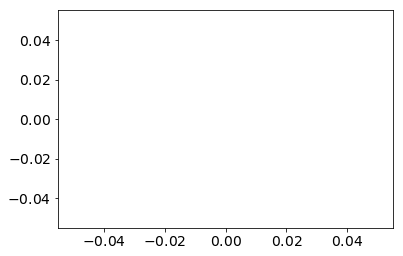

In [54]:
if 'runtimes' in globals():
    if not Nc**ND in sizes:
        runtimes.append(tot)
        sizes.append(Nc**ND)
else:
    runtimes = [tot]
    sizes = [Nc**ND]
print(runtimes)
plt.figure()
plt.plot(sizes,runtimes,'-o')
rt = np.array(runtimes)
sz = np.array(sizes)
ratio_t = rt[1:]/rt[:-1]
ratio_s = sz[1:]/sz[:-1]
plt.figure()
plt.plot(np.log(ratio_t)/np.log(ratio_s))

In [87]:
def J2D_proj_J1D(Jx1D,Jy1D,f,plane=0):
    if plane ==0:
        # Projection in x
        dy = np.diff(Jy1D)[:,np.newaxis]
#         print(np.sum(f,axis=plane).shape,dy.shape,np.sum(dy))
        return np.sum(f*dy,axis=plane)
    elif plane ==1: 
        # Projection in y
        dx = np.diff(Jx1D)
#         print(np.sum(f,axis=plane).shape,dx.shape,np.sum(dx*f))
        return np.sum(f*dx,axis=plane)
    else: 
        print("ERROR in J2D_proj_J1D:  plane must be 0 (horizontal) or 1 (vertical)")

def J1D_proj_x1D(x,J,psi1D):
    # works well except if use .5*rc^2 for Nx=59, when bool_radial=0
    #always ok for X = Jc (Nx<Nxc)
    func = sc.interpolate.interp1d(J,psi1D,kind='linear',bounds_error=False,fill_value='extrapolate')#(0,0))
    psiX = np.zeros_like(x)
    def integrand(J,x):
        if x**2<2*J:
            return func(J)/(np.pi*np.sqrt(J*2-x**2))
        else:
            return 0
    for j,jx in enumerate(x):
#         psiX[j] += sc.integrate.quad(integrand,0,18,args=(jx,),limit=200,epsrel=1e-4,points=[.5*jx**2])[0]
        psiX[j] += sc.integrate.quad(integrand,.5*jx**2,18,args=(jx,),limit=200,epsrel=1e-4,points=[.5*jx**2])[0]
    return psiX


#####################
## Postprocessing: ##
start = time.time()

nrow = calc.G.Ncy
ncol = calc.G.Ncx

## 1 Create Arrays for psi(r), psi(J), dPsidJ


## 2D distribution
psis2D = np.zeros((nt,nrow,ncol))
dPsis2DdJx = np.zeros((nt,(nrow),(ncol-1)))
dPsis2DdJy = np.zeros((nt,(nrow-1),(ncol)))
## 2D -> 1D projection ##
psis1Dx = np.zeros((nt,ncol))
psis1Dy = np.zeros((nt,nrow))    
dPsis1DdJx = np.zeros((nt,ncol-1))
dPsis1DdJy = np.zeros((nt,nrow-1))

Nx=min(51,calc.G.Ncx) ; psisX = np.zeros((nt,Nx)) ; cart_x = np.linspace(-3,3,Nx)
Ny=min(51,calc.G.Ncy) ; psisY = np.zeros((nt,Ny)) ; cart_y = np.linspace(-3,3,Ny)

intensity = np.zeros(nt)
intensity2= np.zeros(nt)

centersepx = np.diff(calc.G.Jxc)
centersepy = np.diff(calc.G.Jyc)

# Fill the arrays
for i in range(nt):
    psis2D[i] = psis[i].reshape((nrow,ncol))
    psis1Dx[i]=J2D_proj_J1D(calc.G.Jxbx,calc.G.Jyby,psis2D[i],0)
    psis1Dy[i]=J2D_proj_J1D(calc.G.Jxbx,calc.G.Jyby,psis2D[i],1)

    intensity[i] = np.sum(psis1Dx[i]*np.diff(calc.G.Jxbx))
    intensity2[i]= np.sum(psis1Dx[i]*np.diff(calc.G.rxbx)*calc.G.rxc)
    
    dPsis2DdJx[i] = np.diff(psis2D[i],axis=1) / centersepx
    dPsis1DdJx[i] = np.diff(psis1Dx[i])       / centersepx
    if calc.ND==2:
        dPsis2DdJy[i] = np.diff(psis2D[i],axis=0) / centersepy[:,np.newaxis]
        dPsis1DdJy[i] = np.diff(psis1Dy[i])       / centersepy
        
        

# Calculate projection on x and y axis in parallel
def worker_psix(i):
    return J1D_proj_x1D(cart_x,calc.G.Jxc,psis1Dx[i])
def worker_psiy(i):
    return J1D_proj_x1D(cart_y,calc.G.Jyc,psis1Dy[i])
nProcs = min(nt,mp.cpu_count()-1)
pool = mp.Pool(processes = nProcs)
psisX = np.array(pool.map(worker_psix,range(nt)))
pool.close()
pool.join()
if calc.ND ==2:
    nProcs = min(nt,mp.cpu_count()-1)
    pool = mp.Pool(processes = nProcs)

    psisY = np.array(pool.map(worker_psiy,range(nt)))
    pool.close()
    pool.join()

print('Postprocessing took %.2fs'%(time.time()-start))

Postprocessing took 2.19s


## 1.3 - Plotting
Requires some cleanup.  
Wait until after 2D solver is implemented.

nt=14 , nplots=100 -> plot_sep=1


<IPython.core.display.Javascript object>


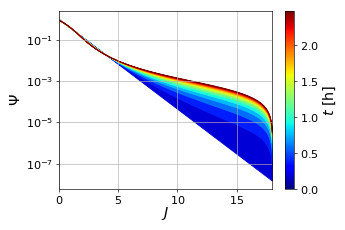

<IPython.core.display.Javascript object>


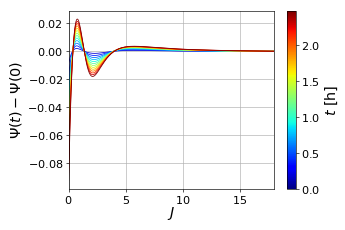

<IPython.core.display.Javascript object>


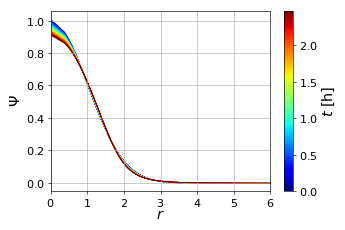

<IPython.core.display.Javascript object>


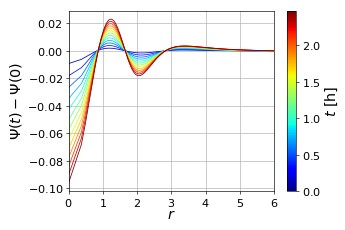

<IPython.core.display.Javascript object>


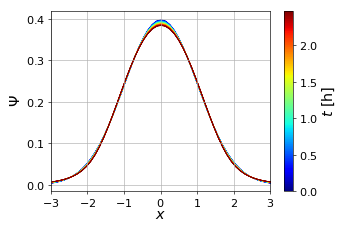

<IPython.core.display.Javascript object>


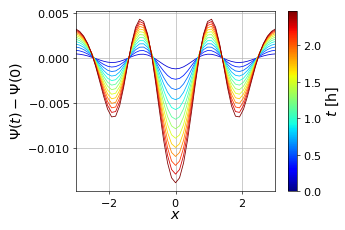

In [88]:
rb,rc = grid.get_rx()
Jb,Jc = grid.get_Jx()
psis1D = psis1Dx

# rb,rc = grid.get_ry()
# Jb,Jc = grid.get_Jy()
# psis1D = psis1Dy


######################################
######## Plotting parameters #########
time_scale = 1    ; tlabel=r'$t$ $[\mathrm{sec}]$'
time_scale = 60   ; tlabel=r'$t$ $[\mathrm{min}]$'
time_scale = 3600 ; tlabel=r'$t$ $[\mathrm{h}]$'

plot_rmax    = 6
bool_savefig = 1
bool_fill    = 1

nplots=100           # nplots: number of curves from psis
plot_sep = int(np.ceil(np.size(tsODE)/nplots))
print('nt=%d , nplots=%d -> plot_sep=%d'%(nt,nplots,plot_sep))

    
#############################
## Plot distribution in 1D ##
sig0 = 1

plt1 = plot_psis_1D(Jc,psis1D,tsODE,0,'log',D0+Dibs,sig0,plot_sep,
                                bool_theory_g0=(g==0),xmax=plot_rmax,bool_fill=bool_fill)

plt2 = plot_psis_1D(rc,psis1D,tsODE,1,'linear',D0+Dibs,sig0,plot_sep,
                                bool_theory_g0=(g==0),xmax=plot_rmax,lw=1,ls='-',bool_fill=bool_fill)
fig1,ax1,fig2,ax2 = plt2

# def plot_psis_1D(x,psis,ts,bool_radial,D=0,sig0=1,plot_sep=1,bool_theory_g0=1,xmax=6,lw=1,ls='-',
#                 fignradd=0,bool_fill=0):
plt3 = plot_psis_1D(cart_x,psisX,tsODE,2,'linear',D0+Dibs,sig0,plot_sep,
                                bool_theory_g0=(g==0),xmax=np.max(cart_x),bool_fill=bool_fill)
if bool_savefig:
    fig1.savefig('03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e.eps'%(
                a,b,g,sigma_k**2*nturns))

    
##################################################
# Problem specific plotting
#Plot incoherent noise curves on top
if 0:
    import matplotlib.lines as mlines
    dir_save = '01_Output'
    with open(dir_save+'/incoherentNoise_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_Np%.0e_Nstep%d.pkl'%(
        a,b,g,sigma_k**2*nturns,1e6,nt),'rb') as pklfile:
        print(pklfile.name)
        storage = pkl.load(pklfile)
    for line in ax1.lines:
#         line.set_ls('-')
        line.set_dashes([3,7])
        line.set_lw(4)
    for i in range(storage['params']['nt']):

        ax1.plot(storage['rcenter'],storage['dist_rs'][i], c=cm.jet(i/(nt-1)),ls='-',lw=1.)
    ax1.set_xlim(0,4)
    ax1.set_ylim(0,1.05)
    dots =  mlines.Line2D([],[],c='k',lw=4,dashes=[3,7],label='Fokker-Planck')
    line =  mlines.Line2D([],[],c='k',ls='-',label='Simulation')
    ax1.legend(handles=[dots,line],frameon=True,borderaxespad=0,borderpad=.4,handletextpad=0,fontsize=14)
    fig1.savefig('03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_compToIncoNoise.eps'%(
        a,b,g,sigma_k**2*nturns))


<IPython.core.display.Javascript object>


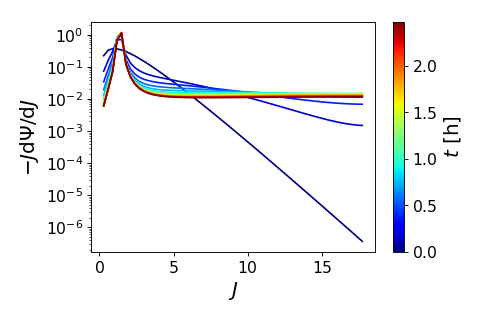

<IPython.core.display.Javascript object>


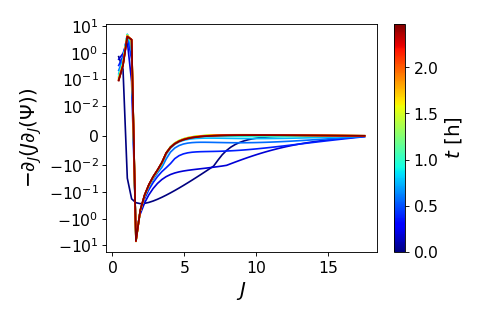

<IPython.core.display.Javascript object>


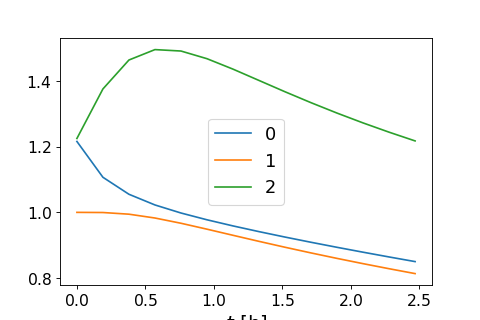

<IPython.core.display.Javascript object>


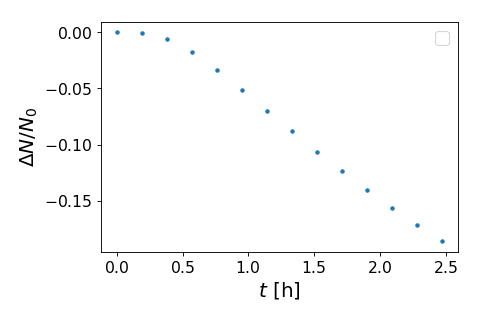

No handles with labels found to put in legend.


In [130]:

#####################################
## Plot derivative of distribution ##
dPsis = dPsis1DdJx
psis = psis1Dx
bool_jdPsidj = 1

fig = plt.figure()
norm = mpl.colors.Normalize(vmin=tsODE.min()/time_scale, vmax=tsODE.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
for i,t in enumerate(tsODE):
    plt.semilogy(Jb[1:-1],-[1,Jb[1:-1]][bool_jdPsidj]*dPsis[i],c=cmap.to_rgba(t/time_scale))
cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
fig.tight_layout()
plt.xlabel(r'$J$')
plt.ylabel(r'$-%s\mathrm{d}\Psi/\mathrm{d}J$'%['','J'][bool_jdPsidj])
plt.tight_layout()
    
#####################################
## Plot double derivative of distribution ##
fig = plt.figure()
norm = mpl.colors.Normalize(vmin=tsODE.min()/time_scale, vmax=tsODE.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
for i,t in enumerate(tsODE[:72]):
    f = -[1,Jb[1:-1]][bool_jdPsidj]*dPsis[i]
    f1= np.diff(f)/np.diff(Jb[1:-1])
    f3= np.zeros_like(f1)
    f3[1:-1] = (f1[2:]-f1[1:-1]+f1[:-2])/np.diff(Jb[2:-2])**2
    plt.plot(Jc[1:-1],2*f1+0*f3,c=cmap.to_rgba(t/time_scale))
plt.yscale('symlog', linthreshy=1e-2)
cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
fig.tight_layout()
plt.xlabel(r'$J$')
plt.ylabel(r'$-\partial_J(%s\partial_J(\Psi))$'%['','J'][bool_jdPsidj])
plt.tight_layout()
    
##################
## Plot moments ##
moments = func_moments(rb,rc,psis,tsODE,bool_radial,bool_FVM)
plt.figure(num=15)
for i in range(3):
    plt.plot(tsODE/time_scale,moments[:,i],label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)
if bool_radial:
    dedtp = (noise.D_ibsx+noise.D_kx)/f_LHC*nturns
    dedtm = moments[-1,2]/2-1
    print('expected emittgrowth = %.2f, vs measured = %.2f'%(dedtp,dedtm))

##############################
## Plot intensity evolution ##
plt.figure(num=16)
if not bool_radial :
    plt.plot(tsODE/time_scale,(moments[:,1]-moments[0,1])/moments[0,1],'.')
else:
    plt.plot(tsODE/time_scale,(moments[:,1]-moments[0,1])/moments[0,1],'.')
plt.ylabel(r'$\Delta N/N_0$')
plt.xlabel(tlabel)
plt.tight_layout()
plt.legend(loc=0)


######################################
## Plot diff and drift coefficients ##
if 0:
    plt.figure(num=17)
    plt.plot([Jb,rb][bool_radial],Diff[:,0],label='Diff')
    plt.plot([Jb,rb][bool_radial],Drift[:,0],label='Drift')
    plt.legend(loc=0)


## 2D plotting

(14, 6400) (80, 80) (80, 80)


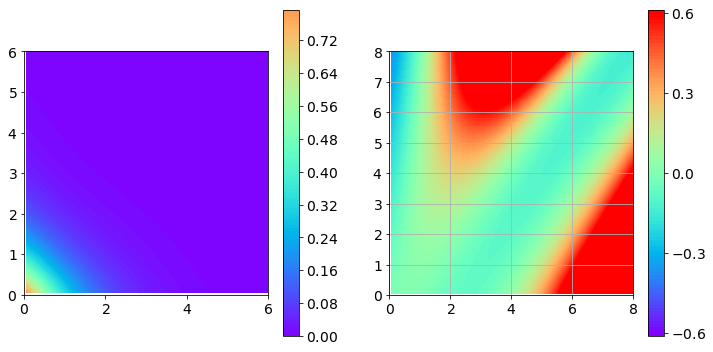

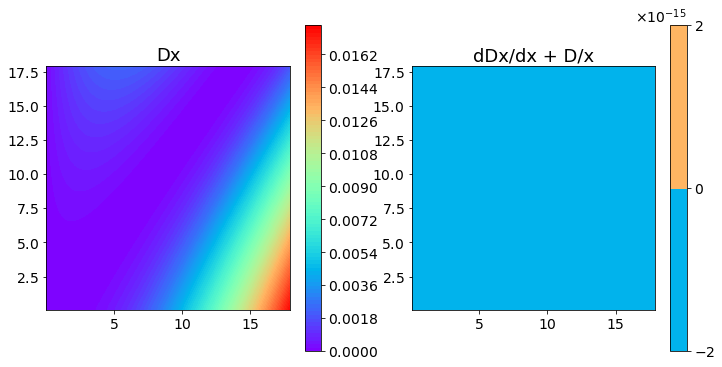

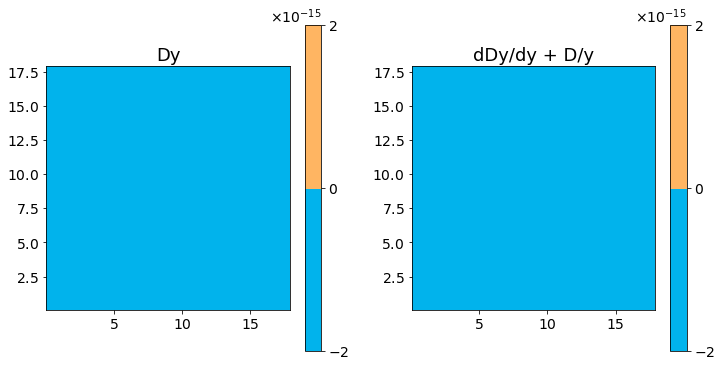

In [11]:
X = calc.G.rxc2D
Y = calc.G.ryc2D
psis = calc.psis
Nx = calc.G.Ncx
Ny = calc.G.Ncy

print(psis.shape,X.shape,Y.shape)
# Distribution

it = 4

fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*Y**2,.5*X**2,psis[it,:].reshape((Ny,Nx)),100,vmin=0,vmax=1)
# plt.pcolor(calc.G.rxn2D,calc.G.ryn2D, psis[it,:].reshape((Ny,Nx)))
plt.colorbar()
jmax=8
rmax = 6
ax1.axis([0,rmax,0,rmax])

ax2= fig.add_subplot(122,aspect='equal')
# plt.contourf(.5*X**2,.5*Y**2,(psis[-1,:]-0*psis[0,:]).reshape((Nx,Ny)),100)
# plt.contourf(.5*X**2,.5*Y**2,((psis[-1,:]-psis[0,:])/psis[0,:]).reshape((Nx,Ny)),np.linspace(-0.1,.1,100))
change = (psis[it,:]-psis[0,:])/psis[0,:]
maxchange = min(1,np.max(np.abs(change))/3) *3
maxchange = .6
levels = np.concatenate(([-1e9],np.linspace(-maxchange,maxchange,100),[1e9]))
cs=plt.contourf(.5*X**2,.5*Y**2,change.reshape((Ny,Nx)),levels,cmap=['seismic','jet','rainbow'][2])
# cs=plt.pcolor(calc.G.Jxn2D,calc.G.Jyn2D,change.reshape((Ny,Nx)),cmap=['seismic','jet','rainbow'][2])
cs.set_clim(-maxchange,maxchange)
ax2.axis([0,jmax,0,jmax])
ax2.grid(True)
cb=plt.colorbar(ticks=np.linspace(-maxchange,maxchange,5))
# cb.ticks()


for i in range(2):
    main = np.array([0,jmax])
    if [a,a][i]==0: continue
    ax=a
    ay=a
    bx=b
    by=b
    Jxavg = calc.G.JxAvg
    Jyavg = calc.G.JyAvg
    continue
    if i==0:
        plt.plot(-1/ax*(bx*main-(ax*Jxavg+bx*Jyavg)),main,'k')
        plt.plot(-1/ax*(bx*main-QxIns),main,'k--')
    else:
        plt.plot(main,-1/ay*(by*main-(ay*Jyavg+by*Jxavg)),'r') #0 for y diff
        plt.plot(main,-1/ay*(by*main-QyIns),'r--')

# Coefficiencts in x diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,calc.DiffE.reshape((Ny,Nx)),100)
plt.title('Dx')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,calc.DriftE.reshape((Ny,Nx)),100)
plt.title('dDx/dx + D/x')
plt.colorbar()

# Coefficiencts in y diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,calc.DiffN.reshape((Ny,Nx)),100)
plt.title('Dy')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,calc.DriftN.reshape((Ny,Nx)),100)
plt.title('dDy/dy + D/y')
plt.colorbar()




# Stability diagrams

In [11]:
# Testing numbers of different detuning coefficients

print(0.82*4/6.5 *1000/0.938)
print(-0.58*4/6.5*1000/0.938)

260*0.938/1000
# 0.82 * 4/6.5 * 

# How to calculate a and b from Nicolas
# https://infoscience.epfl.ch/record/174672/files/EPFL_TH5305.pdf
# /afs/cern.ch/work/l/lhcim/public/IRIS/LHC_IW_model/Python-scripts
IoctF = 1
IoctD = -IoctF
E_gev = 6500
ax =7000/E_gev * (267065/550 * IoctF - 7856  /550*IoctD)
ay =7000/E_gev * (9789  /550 * IoctF - 277203/550*IoctD)
bb  =7000/E_gev *(-102261/550 * IoctF + 93331 /550*IoctD)
print(ax,ay,b)

537.9694931933738
-380.51500738067904
538.3068531468531 561.9423776223775 -0.00011984615384615385


In [89]:
# Calculate stability diagrams    
energy = 6.5
emittance = 2e-6
gamma = energy / 0.938e-3
beta = np.sqrt(1- 1/gamma**2)
emittance_g=emittance/(beta*gamma)
i_octupoles = 400
# i_octupoles = np.arange(-500, 0, 50)
a_x =  0.82*4 * i_octupoles*emittance/energy**2
b_x = -0.58*4 * i_octupoles*emittance/energy**2

# Result from own paper
a_x = 520*i_octupoles*emittance_g
b_x =-380*i_octupoles*emittance_g 
integrator_epsilon = 2e-7

a_x = a 
b_x = b 

a_y = a_x
b_y = b_x

# a_x = a
# a_y = b
# b_x = 0 ; b_y = 0 ; integrator_epsilon = 1e-6

print('a_x=%.3e \na_y=%.3e'%(a_x,a_y))
print(a_x/emittance_g,a_y/emittance_g)
print(integrator_epsilon)


# a_x=1.72e-07 *100
# a_y=-1.15e-07*100



psisJ = psis1Dx
dPsis = dPsis1DdJx
    

def collect_result(res):
    results.append(res)
    
def calc_Stability_Diagram(args):
    # Take input
    [i,plane, psi,dPsi,a,b,nQ,debug] =args
    if debug: print('entry ok',i)
    #Set distribution
    if   plane < 0: 
        distribution = Gaussian()
    else:
        if calc.ND==1:
            if plane ==0: distribution = MyDistribution1D( Jb,Jc, psi,dPsi)
            else:         distribution = MyDistribution1Dy(Jb,Jc, psi,dPsi)
        else:
            if plane ==0: 
                distribution = MyDistribution2D(calc.G.Jxbx,calc.G.Jxc,calc.G.Jyby,calc.G.Jyc,
                                            psis2D[i],dPsis2DdJx[i],dPsis2DdJy[i],interp_order=0)
            else:
                distribution = MyDistribution2Dy(calc.G.Jxbx,calc.G.Jxc,calc.G.Jyby,calc.G.Jyc,
                                            psis2D[i],dPsis2DdJx[i],dPsis2DdJy[i],interp_order=0)
#                 distribution = MyDistribution2D(calc.G.Jyby,calc.G.Jyc,calc.G.Jxbx,calc.G.Jxc,
#                                             psis2D[i].T,dPsis2DdJy[i].T,dPsis2DdJx[i].T,interp_order=0)
    if debug: print('distribution ok',i)

    detuning = LinearDetuning(.31, a, b)
    #Instead take stability in other plane
    if plane ==1:
#         distribution = MyDistribution1Dy( Jb,Jc, psi,dPsi) # need dispersion(Jy*dPsi/dJ)
        detuning = LinearDetuning(.32, a, b)
    
    
#     integrator = SimpsonIntegrator(distribution, detuning, maxJ=18)
    integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
#     integrator = DblquadIntegrator(distribution, detuning, maxJ=18)
    if debug: print('setup ok',i)
    t0 = time.clock()
#         tunes = get_tune_range(detuning)
    tunes = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
    tune_shifts = np.zeros((len(tunes)), dtype='complex')
    for k, q in enumerate(tunes):
        tune_shifts[k] = integrator.integrate(q,epsilon=integrator_epsilon)
    
#     Norm = trapezoidal(Jb,psi,1)
#     Norm = 1
    
    # Timing
    t1 = time.clock()-t0
    print("Elapsed times (%d,%s): %.2fs."%(i,['x','y'][plane],t1))
    return (i,tune_shifts,tunes)
        
    
    
indexSD = np.arange(0,nt,2)
tsSD = tsODE[indexSD]
ntSD = np.size(indexSD)
nQ = 50
print(indexSD)

debug=0


for plane in [0,1]:
#     continue
    
    if plane==0  : 
        tune_shifts_all1 = np.zeros((ntSD,nQ),dtype='complex')
        tunes_Q_all1     = np.zeros((ntSD,nQ))
    elif plane==1: 
        tune_shifts_all2 = np.zeros((ntSD,nQ),dtype='complex')
        tunes_Q_all2     = np.zeros((ntSD,nQ))
    else:
        continue
    tune_shifts_calculated = np.zeros_like(tsODE)

    #Paralellisation preperation
    nProcs = min(np.size(indexSD),mp.cpu_count()-1)
    print("%d processes"%nProcs)
    pool = mp.Pool(processes = nProcs)

    procs = []
    results = []
    
    for ind,i in enumerate(indexSD):
        t = tsODE[i]
        # Parallellisation
        if i==0:
            args = [ind,plane,psisJ[i],dPsis[i],a_x,b_x,nQ,debug]
        else:
            args = [ind,plane,psisJ[i],dPsis[i],a_y,b_y,nQ,debug]
        p = pool.apply_async(calc_Stability_Diagram, args = (args,),callback = collect_result)
        procs.append(p)
    
    ###################
    # Join forces again
    pool.close()
    pool.join()
    
    for j,_ in enumerate(indexSD):
#         print(results[j])
        print(i,j)
        i,res,res2 = results[j]
        if plane==0: 
            tune_shifts_all1[i]= res
            tunes_Q_all1[i] = res2
        else:
            tune_shifts_all2[i]= res
            tunes_Q_all2[i] = res2
        tune_shifts_calculated[i]=1
        

if 1:
    args = [-1,-1,np.arange(2),np.arange(2),a_x/2,b_x/2,nQ,debug]
    tune_shifts_halfI = calc_Stability_Diagram(args)[1]



a_x=1.000e-04 
a_y=1.000e-04
346481.8727249303 346481.8727249303
2e-07
[ 0  2  4  6  8 10 12]
7 processes
entry ok 0
distribution ok 0
entry ok 2
entry ok 1
distribution ok 1
entry ok 3
distribution ok 2
entry ok 4
distribution ok 3
entry ok 6
setup ok 0
distribution ok 4
distribution ok 6
setup ok 1
entry ok 5
distribution ok 5
setup ok 2
setup ok 4
setup ok 3
setup ok 6
setup ok 5
Elapsed times (4,x): 14.98s.
Elapsed times (6,x): 15.07s.
Elapsed times (2,x): 15.65s.
Elapsed times (5,x): 15.42s.
Elapsed times (1,x): 15.45s.
Elapsed times (0,x): 15.49s.
Elapsed times (3,x): 15.30s.
12 0
4 1
6 2
2 3
5 4
1 5
0 6
7 processes
entry ok 2
entry ok 3
entry ok 1
entry ok 0
entry ok 5
entry ok 6
entry ok 4
distribution ok 1
distribution ok 3
distribution ok 2
distribution ok 5
distribution ok 0
setup ok 5
distribution ok 4
setup ok 3
setup ok 0
distribution ok 6
setup ok 2
setup ok 4
setup ok 1
setup ok 6
Elapsed times (3,y): 15.81s.
Elapsed times (1,y): 15.45s.
Elapsed times (4,y): 15.38s.
Ela

Elapsed times (2,y): 11.83s.
Elapsed times (6,y): 12.37s.
Elapsed times (3,y): 12.66s.
Elapsed times (0,y): 13.37s.
Elapsed times (5,y): 12.96s.
Elapsed times (1,y): 13.24s.
Elapsed times (4,y): 13.59s.
Elapsed times (7,y): 11.64s.
Elapsed times (10,y): 12.46s.
Elapsed times (8,y): 12.86s.
Elapsed times (9,y): 13.44s.
Elapsed times (11,y): 13.19s.
Elapsed times (12,y): 12.80s.
Elapsed times (13,y): 13.42s.
Elapsed times (14,y): 12.94s.
Elapsed times (18,y): 12.74s.
Elapsed times (16,y): 13.09s.
Elapsed times (17,y): 12.47s.
Elapsed times (19,y): 12.93s.
Elapsed times (15,y): 13.31s.
Elapsed times (20,y): 13.29s.
Elapsed times (21,y): 13.62s.
Elapsed times (22,y): 12.83s.
Elapsed times (24,y): 12.72s.
Elapsed times (23,y): 13.11s.
Elapsed times (26,y): 12.66s.
Elapsed times (27,y): 12.53s.
Elapsed times (25,y): 13.08s.


<IPython.core.display.Javascript object>


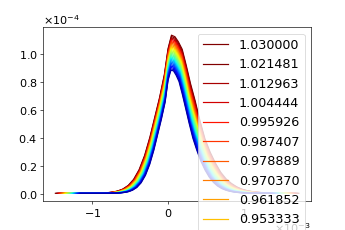

1.03
1.0214814814814814
1.012962962962963
1.0044444444444445
0.995925925925926
0.9874074074074074
0.9788888888888889
0.9703703703703704
0.9618518518518518
0.9533333333333334
0.9448148148148149
0.9362962962962963
0.9277777777777778
0.9192592592592593
0.9107407407407407
0.9022222222222223
0.8937037037037038
0.8851851851851853
0.8766666666666667
0.8681481481481482
0.8596296296296297
0.8511111111111112
0.8425925925925927
0.8340740740740742
0.8255555555555556
0.8170370370370371
0.8085185185185186
0.8


In [75]:
if not ('tunes_gauss' in globals()) :
    nSD_G=28
    parts = np.linspace(1.03,.8,nSD_G)
    def worker_SD(i):
        args = [i,-1,np.arange(2),np.arange(2),parts[i]*a_x,parts[i]*b_x,nQ,debug]
        return calc_Stability_Diagram(args)

    nProcs = min(nSD_G,mp.cpu_count()-1)
    pool = mp.Pool(processes = nProcs)
    SD_output = pool.map(worker_SD,range(nSD_G))
    pool.close()
    pool.join()
    
plt.figure()
strength=[]
tunes_gauss=[]
tunes_Q_gauss=[]
for i in range(nSD_G):
    print(parts[i])
    j,x,y = SD_output[i]
    plt.plot(x.real,x.imag,c= cm.jet((nSD_G-i)/(nSD_G-1)),label='%f'%parts[i])
    strength.append(parts[j])
    tunes_gauss.append(x)
    tunes_Q_gauss.append(y)
plt.legend()

<IPython.core.display.Javascript object>


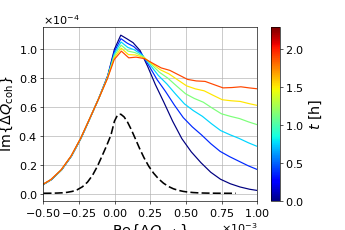

<IPython.core.display.Javascript object>


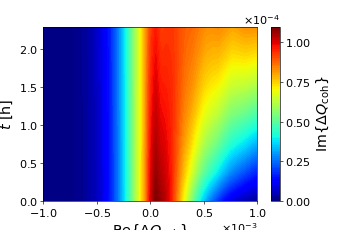

False [  0.      1.104   2.208   3.313   4.417   5.521   6.625   7.729   8.834
   9.938  11.042  12.146  13.25   14.355  15.459  16.563  17.667  18.771
  19.876  20.98   22.084  23.188  24.292  25.397  26.501  27.605  28.709
  29.813  30.918  32.022  33.126  34.23   35.334  36.439  37.543  38.647
  39.751  40.855  41.96   43.064  44.168  45.272  46.376  47.481  48.585
  49.689  50.793  51.897  53.002  54.106  55.21   56.314  57.418  58.523
  59.627  60.731  61.835  62.939  64.044  65.148  66.252  67.356  68.461
  69.565  70.669  71.773  72.877  73.982  75.086  76.19   77.294  78.398
  79.503  80.607  81.711  82.815  83.919  85.024  86.128  87.232  88.336
  89.44   90.545  91.649  92.753  93.857  94.961  96.066  97.17   98.274
  99.378 100.482 101.587 102.691 103.795 104.899 106.003 107.108 108.212
 109.316]


<IPython.core.display.Javascript object>


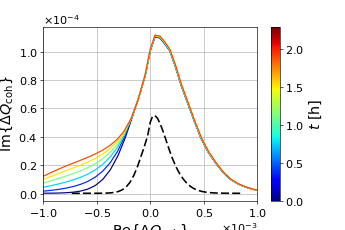

<IPython.core.display.Javascript object>


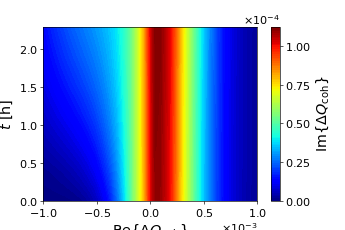

False [  0.      1.13    2.26    3.39    4.52    5.649   6.779   7.909   9.039
  10.169  11.299  12.429  13.559  14.688  15.818  16.948  18.078  19.208
  20.338  21.468  22.598  23.728  24.857  25.987  27.117  28.247  29.377
  30.507  31.637  32.767  33.896  35.026  36.156  37.286  38.416  39.546
  40.676  41.806  42.935  44.065  45.195  46.325  47.455  48.585  49.715
  50.845  51.975  53.104  54.234  55.364  56.494  57.624  58.754  59.884
  61.014  62.143  63.273  64.403  65.533  66.663  67.793  68.923  70.053
  71.183  72.312  73.442  74.572  75.702  76.832  77.962  79.092  80.222
  81.351  82.481  83.611  84.741  85.871  87.001  88.131  89.261  90.39
  91.52   92.65   93.78   94.91   96.04   97.17   98.3    99.43  100.559
 101.689 102.819 103.949 105.079 106.209 107.339 108.469 109.598 110.728
 111.858]


In [76]:
bool_save = 0
bool_SD_constituents=0
bool_fill =0
def plot_stability(tune_shifts_all,tunes_Q_all,tune_shifts_calculated,ts,time_scale,savedir,figname):
    fig, ax = plt.subplots(1)#, figsize=(16, 15))
    # col = sns.color_palette("husl", len(tsODE), 0.6)

    # Set colorbar as time measurement:
    norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    cmap.set_array([])
    
    for i,t in enumerate(ts):
#         if i%2==0:continue
        if not tune_shifts_calculated[i] or t==ts[-1]: continue
        if bool_fill:
            ax.fill(np.concatenate((tune_shifts_all[i].real,tune_shifts_all[i+1][::-1].real)),
                    np.concatenate((tune_shifts_all[i].imag,tune_shifts_all[i+1][::-1].imag)),
                    color=cmap.to_rgba(t/time_scale))
                #,label=r'$t=%.2f$ $%s$'%(t/time_scale,tlabel[6:-2]))
        else :
#         elif 1:
            ax.plot(tune_shifts_all[i].real, tune_shifts_all[i].imag, c=cmap.to_rgba(t/time_scale)) 
    #         ax.fill_between(tune_shifts_all[i].real,tune_shifts_all[i].imag,tune_shifts_all[i+1].imag,
    #                         color=cmap.to_rgba(t/time_scale),interpolate=True)



    ax.set_xlabel("$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$")#, fontsize=20)
    ax.set_ylabel("$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$")#, fontsize=20)
#     ax.legend(loc=0)
    ax.grid(True)
    #finish colorbar
    cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
    tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
#     fig.tight_layout()
    
    
    if bool_save: fig.savefig(savedir+'%s.eps'%(figname))
    
    ####################################################################################
    ####################################################################################
    if bool_SD_constituents:
        fig2,ax2 =plt.subplots(2,1,sharex=True)
        # Set colorbar as time measurement:
        norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
        cmap.set_array([])

        for i,t in enumerate(ts):
            if not tune_shifts_calculated[i] or t==ts[-1]: continue
            Q =  tunes_Q_all[i]
            ax2[0].plot(Q/a_x,tune_shifts_all[i].real-Q, c=cmap.to_rgba(t/time_scale)) 
            ax2[1].plot(Q/a_x,tune_shifts_all[i].imag, c=cmap.to_rgba(t/time_scale)) 
        ax2[0].set_ylabel(r'Real $\Delta Q - Q$')
        ax2[1].set_ylabel(r'Imag $\Delta Q$')
        ax2[1].set_xlabel(r'$J$')
        for i in range(2):
            ax2[i].grid(True)
    #     cb=fig2.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
    #     tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    #     cb.locator = tick_locator
    #     cb.update_ticks()
        fig2.tight_layout()
        fig2.subplots_adjust(hspace=0)
    
    ####################################################################################
    ####################################################################################
        fig2,ax2 =plt.subplots(2,1,sharex=True)
        # Set colorbar as time measurement:
        norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
        cmap.set_array([])

        for i,t in enumerate(ts):
            if not tune_shifts_calculated[i] or t==ts[-1]: continue
            Q =  tunes_Q_all[i]
            ReDQ = tune_shifts_all[i].real
            ImDQ = tune_shifts_all[i].imag
            ReInt= -ReDQ / (ReDQ**2 + ImDQ**2)
            ImInt=  ImDQ / (ReDQ**2 + ImDQ**2)
            ax2[0].plot(Q/a_x, ReInt, c=cmap.to_rgba(t/time_scale)) 
            ax2[1].plot(Q/a_x, ImInt, c=cmap.to_rgba(t/time_scale)) 
        ax2[0].set_ylabel('Real integral')
        ax2[1].set_ylabel('Imag integral')
        ax2[1].set_xlabel(r'$J$')
        for i in range(2):
            ax2[i].grid(True)
    #     cb=plt.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
    #     tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    #     cb.locator = tick_locator
    #     cb.update_ticks()
        fig2.tight_layout()
        fig2.subplots_adjust(hspace=0)

    return fig



def waterfallSD(tune_shifts_all,tune_shifts_calculated,ts,time_scale,basex):
    nt = np.size(ts)
    nx = np.size(basex)
    AllY = np.zeros((nt,nx))
    for i in range(nt):
        if not tune_shifts_calculated[i]: continue
        x = tune_shifts_all[i].real
        y = tune_shifts_all[i].imag
        f = sc.interpolate.interp1d(x,y,kind='linear',bounds_error=False,fill_value=0)
        AllY[i] = f(basex)
    
    fig = plt.figure()
    ax=fig.gca()
    cmap = 'jet'
    lims = [0,min(np.max(AllY),3*np.max(AllY[:,int(nx/2)]))]
    
    levels=np.linspace(lims[0],lims[1],100)
    if np.max(AllY)>levels[-1] and 1:
        levels = np.concatenate((np.linspace(lims[0],lims[1]*.33,100)
                                ,np.linspace(np.max(AllY),lims[1]*.33,100,endpoint=False)[::-1]))
        levels = np.linspace(0,np.max(AllY),200)
        clowratio=.9 # part of colors contained by the low levels
        llowratio = int(np.max(AllY[0,:])/np.max(AllY) * 200 * 2) # number of points for the low levels
        clrlevels= np.concatenate((np.linspace(0,clowratio,llowratio,endpoint=False)
                                  ,np.linspace(clowratio,1,200-llowratio)))
        jet = cm.get_cmap('jet')
        newclrs = jet(clrlevels)
        cmap  = mpl.colors.ListedColormap(newclrs)
        lims[1] = np.max(AllY)
    
#     plt.imshow(np.flipud(AllY),cmap=cmap,aspect='auto', extent=(np.min(basex),np.max(basex),0,np.max(ts)/time_scale)
#                ,interpolation=['quadric','none'][0],vmin=lims[0],vmax =lims[1] )
    print(np.max(AllY)==0,levels*1e6)
    plt.contourf(AllY,cmap=cmap,levels=levels,extent=(np.min(basex),np.max(basex),0,np.max(ts)/time_scale))
    cb = plt.colorbar(label = "$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$")
    tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    
    
    ax.set_xlabel("$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$")#, fontsize=20)
    ax.set_ylabel(tlabel)
#     fig.tight_layout()
    
    return fig


######################################################################
######################################################################
savedir = '04_Plots_Diffusion/'
for i in [0,1]:
    figi = plot_stability([tune_shifts_all1,tune_shifts_all2][i],[tunes_Q_all1-0.31,tunes_Q_all2-0.32][i],
                          tune_shifts_calculated,tsSD,time_scale,savedir,
                     figname = 'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_Ioct%.0f_en%.1fum'%(['x','y'][i],
                               a,b,g,BC_xMax,i_octupoles,emittance*1e6))
    
    basex = np.linspace(-1,1,100)*1.0e-3
    figj = waterfallSD([tune_shifts_all1,tune_shifts_all2][i],tune_shifts_calculated,
                    tsSD,time_scale,basex)

    if 1:
        axi = figi.gca()
        axi.plot(tune_shifts_halfI.real, tune_shifts_halfI.imag, c='k',ls='--',lw=2,dashes=(5, 2)
                    ,label=r'$I_\mathrm{oct}=%.0f$ $\mathrm{A}$'%(200))
    #     axi.legend(loc=0)
#         axi.set_ylim(0,np.max(tune_shifts.imag)*4)
        axi.set_xlim(-1e-3*[.5,1][i],1e-3)
#         figi.tight_layout()
        
        if bool_save: 
            fname = savedir+'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_Ioct%.0f_en%.1fum_digginglimit'%(['x','y'][i],
                               a,b,g,BC_xMax,i_octupoles,emittance*1e6)
            figi.savefig(fname+'.eps',format='eps', dpi=figi.dpi)
            figi.savefig(fname+'.pdf',format='pdf', dpi=figi.dpi)

            fname = savedir+'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_Ioct%.0f_en%.1fum_waterfall'%(['x','y'][i],
                               a,b,g,BC_xMax,i_octupoles,emittance*1e6)
            figj.savefig(fname+'.eps',format='eps', dpi=figi.dpi)


(7, 50)
[[0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309
  0.309 0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31
  0.31  0.31  0.31  0.31  0.31  0.311 0.311 0.311 0.311 0.311 0.311 0.311
  0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.312 0.312 0.312
  0.312 0.312]
 [0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309
  0.309 0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31
  0.31  0.31  0.31  0.31  0.31  0.311 0.311 0.311 0.311 0.311 0.311 0.311
  0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.312 0.312 0.312
  0.312 0.312]
 [0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309
  0.309 0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.31
  0.31  0.31  0.31  0.31  0.31  0.311 0.311 0.311 0.311 0.311 0.311 0.311
  0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.312 0.312 0.312
  0.312 0.312]
 [0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 0.309 

<IPython.core.display.Javascript object>


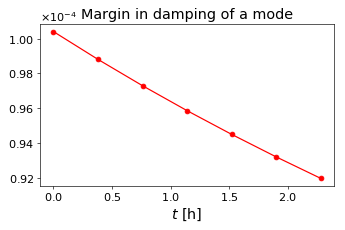

In [118]:
mode = 0e-4 + 0e-6j
mode_R = np.real(mode)
mode_I = np.imag(mode)

print(tune_shifts_all1.shape)
print(tunes_Q_all1)

SD_margin = np.zeros(ntSD)

tunes_Q = tunes_Q_all1
tune_shifts =tune_shifts_all1

for i in range(ntSD):
    tune_Q = tunes_Q[i]
    dQ = tune_shifts[i]
    
    dQ_R = np.real(dQ)
    flag_nonmonotone = np.any(np.diff(dQ_R)<0)
    if flag_nonmonotone:
        print("dQ_R is not strictly increasing...")
        print(dQ_R*1e5-0.31)
        
    dQ_I = np.imag(dQ)
    right = np.searchsorted(dQ_R,mode_R)
    if right==0:
        right+=1
    left = right-1
    
    if dQ_R[left]>=dQ_R[right]:
        print("Big problem - left values is larger than right value...")
    dIdR = (dQ_I[right]-dQ_I[left])/(dQ_R[right]-dQ_R[left])
    dQ_I_mode = dQ_I[left] + dIdR*(mode_R-dQ_R[left])
    
    
    SD_margin[i] = dQ_I_mode-mode_I
    print(("R(dQ)=%.1e, I(dQ)=%.1e, SD_dQx=%.1e, iL=%d, iR=%d \nx(L,R)=(%.2e,%.2e), dx=%.2e, xi-xL=%.2e\n"+
          "y_(L,R)=(%.2e,%.2e)\n")%(
            mode_R,mode_I,dQ_I_mode,left,right,dQ_R[left],dQ_R[right],(dQ_R[right]-dQ_R[left]),
            (mode_R-dQ_R[left]),dQ_I[right],dQ_I[left]))

#     print(dQx_R)

plt.figure()
plt.plot(tsSD/time_scale,SD_margin,'ro-')
plt.title('Margin in damping of a mode')
plt.xlabel(tlabel)
plt.tight_layout()

<IPython.core.display.Javascript object>


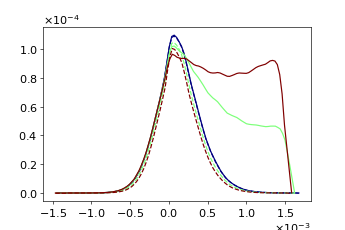

happy 2.609143214122434e-07
interp strength 9.96e-01 -> 9.98e-01, ds=-8.52e-03, dm=9.05e-07
happy 4.5979053684501426e-07
interp strength 9.79e-01 -> 9.83e-01, ds=-8.52e-03, dm=8.98e-07
happy 6.96145417527244e-07
interp strength 9.62e-01 -> 9.69e-01, ds=-8.52e-03, dm=8.68e-07
happy 1.0472637704745703e-07
interp strength 9.53e-01 -> 9.54e-01, ds=-8.52e-03, dm=8.47e-07
happy 3.687590879560877e-07
interp strength 9.36e-01 -> 9.40e-01, ds=-8.52e-03, dm=8.05e-07
happy 6.369044727279273e-07
interp strength 9.19e-01 -> 9.26e-01, ds=-8.52e-03, dm=7.78e-07
happy 1.7103584388968723e-07
interp strength 9.11e-01 -> 9.13e-01, ds=-8.52e-03, dm=7.72e-07


<IPython.core.display.Javascript object>


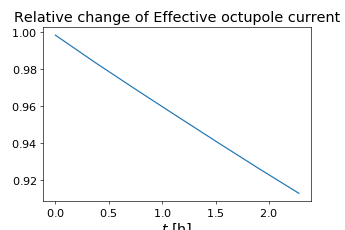

Text(0.5, 1.0, 'Relative change of Effective octupole current')

In [120]:
# strength
# tunes_gauss
# tunes_Q_gauss
%matplotlib notebook


tunes_Q = tunes_Q_all1
tune_shifts =tune_shifts_all1
kind ='linear'
bool_interpStrength = 1
bool_all_dQ_R = 0
mode_R = 0e-4

SD_limit = np.zeros(ntSD)


plt.figure(64)

for i in range(ntSD):
    tune_Q = tunes_Q[i]
    dQ = tune_shifts[i]
    
    dQ_R = np.real(dQ)
    flag_nonmonotone = np.any(np.diff(dQ_R)<0)
    if flag_nonmonotone:
        print("dQ_R is not strictly increasing...")
        print(dQ_R*1e5-0.31)
        
    dQ_I = np.imag(dQ)
        
    dQ_R_plot = np.linspace(dQ_R[0],dQ_R[-1],100)    
    if bool_all_dQ_R:
        ind = dQ_I > np.max(dQ_I)/100
        dQ_R_test = np.linspace(dQ_R[ind][0],dQ_R[ind][-1],100)    
    else:
        dQ_R_test = mode_R
        
    
    interp_SD = sc.interpolate.interp1d(dQ_R,dQ_I,kind=kind,bounds_error=False,fill_value=0)
    for j in range(nSD_G):
        interp_G  = sc.interpolate.interp1d(tunes_gauss[j].real,tunes_gauss[j].imag,kind=kind,bounds_error=False,fill_value=0)
        newmargin = np.min(interp_SD(dQ_R_test)-interp_G(dQ_R_test))
        if newmargin>0:
            if i%3==0:
                plt.plot(dQ_R_plot,interp_SD(dQ_R_plot),c=cm.jet((i)/(ntSD-1)))
                plt.plot(dQ_R_plot,interp_G( dQ_R_plot),'--',c=cm.jet((i)/(ntSD-1)))
            print('happy',newmargin)
            
            SD_limit[i] = strength[j]
            if j>0 and bool_interpStrength:
                dsdm = (strength[j]-strength[j-1])/(newmargin-oldmargin)
                SD_limit[i] = strength[j] - dsdm * newmargin
                print('interp strength %.2e -> %.2e, ds=%.2e, dm=%.2e'%(strength[j],SD_limit[i],
                                                                       (strength[j]-strength[j-1]),(newmargin-oldmargin)))
            break
        oldmargin = newmargin
#         print(i,j,newmargin)
        
    
plt.figure()
plt.plot(tsSD/time_scale,SD_limit)
plt.xlabel(tlabel)
plt.title("Relative change of Effective octupole current")

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


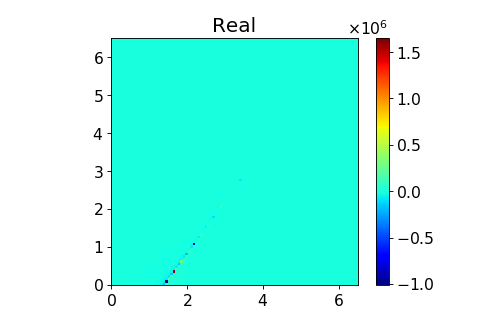

<IPython.core.display.Javascript object>


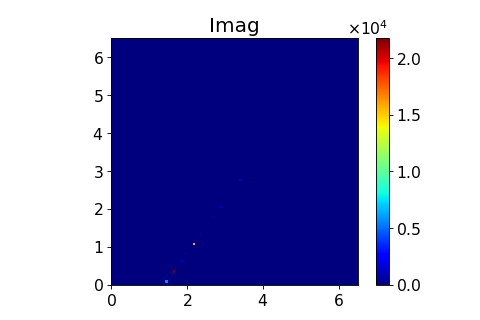

In [267]:
def plot_integrand(psi,dPsi,Q0,Q,jmax=18):
    distribution = MyDistribution1D( Jb,Jc, psi,dPsi)
    detuning = LinearDetuning(Q0, a_x, b_x)
    dispersion = Dispersion(distribution,detuning,Q,integrator_epsilon/100)
    x = np.linspace(0,jmax,100)
    JX,JY = np.meshgrid(x,x)
    integrand = dispersion.getValue(JX,JY)
    cmap  = 'jet'
    plt.figure()
    plt.imshow(np.flipud(integrand.real),extent=(0,jmax,0,jmax),cmap=cmap)
    plt.colorbar()
    plt.title('Real')
    plt.figure()
    plt.imshow(np.flipud(integrand.imag),extent=(0,jmax,0,jmax),cmap=cmap)
    plt.colorbar()
    plt.title('Imag')
i = 1
plot_integrand(psisJ[i],dPsis[i],0.31,0.31+1.4*a_x,6.5)

<IPython.core.display.Javascript object>


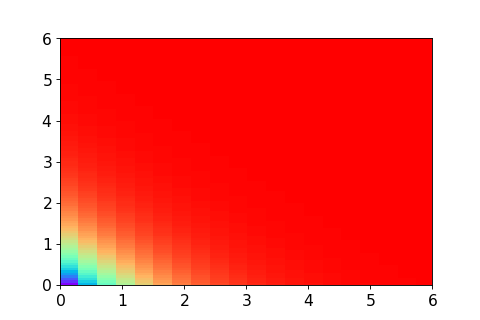

In [40]:
distribution = MyDistribution1D( Jb,Jc, psisJ[0],dPsis[0])
XX,YY = np.meshgrid(np.linspace(0,6,100),np.linspace(0,6,100))
plt.figure()
plt.pcolor(XX,YY,distribution.getDJy(XX,YY))

jet = cm.get_cmap('jet')
levels = np.concatenate((np.arange(10),(np.linspace(11,12,10))))
lev0 =np.min(levels) ;lev1 = np.max(levels)
newclrs = jet((levels-lev0)/(lev1-lev0))
newmap  = mpl.colors.ListedColormap(newclrs)

In [41]:
# Simple testing
for i,t in enumerate(tsODE):
    if i!=1: continue
    psiJ = psis[i]
    if bool_radial:
        psiJ = psiJ*rc*h/np.diff(Jb)
    
    dpsi = np.diff(psiJ)/np.diff(Jc)
    plt.figure()
    plt.plot(Jc,psiJ,'rx')
    plt.plot(Jc,np.exp(-Jc),'b--')
    plt.yscale('log')
    
    distribution = MyDistribution1D(Jb,Jc,psiJ,dpsi)
    Js = np.linspace(0,7,200)
    f  = np.zeros_like(Js)
    df = np.zeros_like(Js)
    for j,jx in enumerate(Js):
        f[j] = distribution.getValue(jx,0)
        df[j]= distribution.getDJx(jx,0)
    plt.plot(Js,f,'x')
    plt.plot(Js,-df,'o')

ValueError: operands could not be broadcast together with shapes (3599,) (59,) 

# Plot COMBI results

In [379]:
import os
nbin=200
folder = 'dx0.0_N1-5e-03_g2.0e-01_OPa5.0e-03_OPb0.0e+00_Qp0_Qs0.000_np4.0e+06_nt4e+06_dt5e+05'
inputdir = '02_Input/'+folder+'/'
postDist1D_name = inputdir + 'postDistribution1D_nbin%d'%(nbin)
plotdir = '03_Plots'
with open(postDist1D_name,'rb') as pklfile:
    output = pkl.load(pklfile)
SIGMAS = output['sigma0'] 
turns = output['turns']
turnZ = np.max(output['turns'])
PSIS = np.zeros((np.size(turns),nbin-1))
x = edges_to_center(output['bins0Z']*output['rMax'])
for i,turn_i in enumerate(turns):
    for plane in [0]: #Horizontal
        PSIS[i] = output[turn_i]['rAbs'][plane]/x

fig1,ax1,_,_=plot_psis_r(x,np.array(PSIS),np.array(turns)/f_LHC*25,bool_radial,
            D=0,sig0=1,plot_sep=1,bool_theory_g0=0,xmax=4,lw=1,fignradd=11)
ax1.set_ylim(0,1)

fig1.savefig('03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_CoNoise.eps'%(
            5e-3,0,0.2,(5e-3)**2*4e6))

NameError: name 'time_scale' is not defined

[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000]


<IPython.core.display.Javascript object>


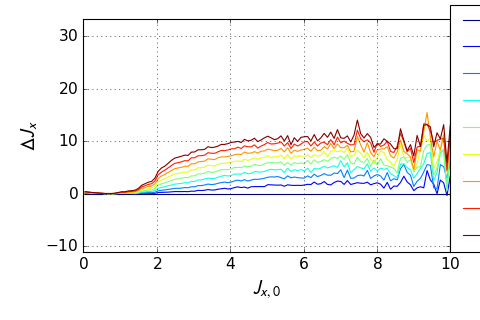

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


<IPython.core.display.Javascript object>


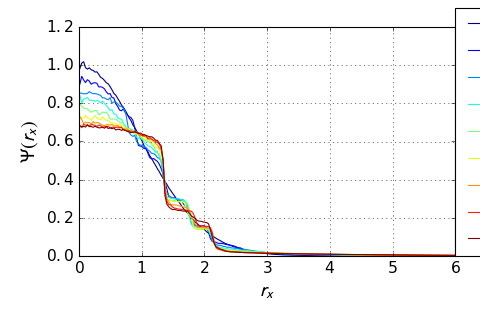

<IPython.core.display.Javascript object>


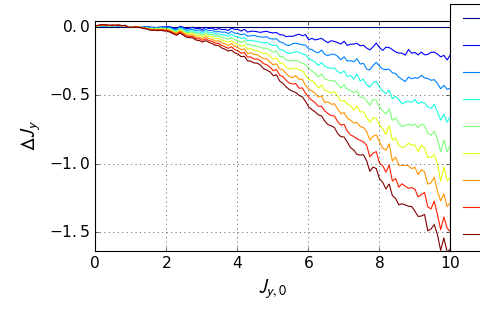

<IPython.core.display.Javascript object>


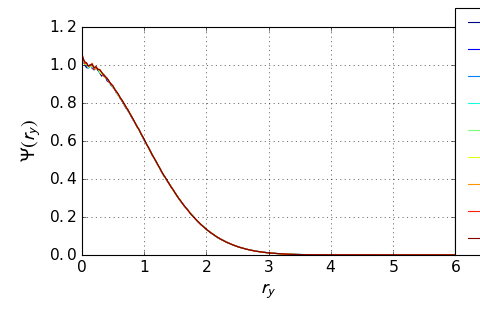

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [74]:




for i,turn_i in enumerate(output['turns']):
    c = cm.jet(turn_i/turnZ)
    lab_turn = '%dk turns'%(turn_i/1000)

    for plane in [0,1]:
        plt.figure(1+plane)
        x = edges_to_center(output['bins0Z']*output['jMax'])
        y = output[turn_i]['djAbs'][plane]
        plt.plot(x,y,c=c,label=lab_turn)
        plt.ylim(min(-np.max(y[x<6]),np.min(y[x<6])*3),np.max(y[x<6])*3)

        plt.figure(4+plane)
        x = edges_to_center(output['bins0Z']*output['rMax'])
        y = output[turn_i]['rAbs'][plane]/x
        plt.plot(x,y,c=c,label=lab_turn)

for plane in [0,1]:   
    xx = ['x','y'][plane]


    plt.figure(1+plane)
    x = edges_to_center(output['bins0Z']*output['jMax'])
    plt.legend(loc=(1,0))
    plt.ylabel(r'$\Delta J_%s$'%xx)
    plt.xlabel(r'$J_{%s,0}$'%xx)
    plt.grid(True)
    plt.xlim(0,10)
    plt.tight_layout()
    plt.savefig(plotdir +'/DDIST_%s_DACT_1D_dJ%s.png'%(folder,xx))

    plt.figure(4+plane)
    plt.legend(loc=(1,0))
    plt.ylabel(r'$\Psi(r_%s)$'%xx)
    plt.xlabel(r'$r_{%s}$'%xx)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plotdir +'/DDIST_%s_DIST_1D_rad%s.png'%(folder,xx))


## 1D testing

In [906]:
pi2 = 2*np.pi
eps = 1e-2

a = 1e-3
b = 0
g = 1e-2 *0
g2 = g/2 


def trapezoidal(x,y,bool_center=0):
    if bool_center:
        dx = np.diff(x)[0]
        return np.sum(dx*y)
    else:
        return np.sum(np.diff(x)*(y[1:]+y[:-1]))*0.5

def simp(x,y,bool_center=0):
    if bool_center:
        print('CANNOT CALCULATE')
        return np.nan
    else:
        rest = (np.size(x)-1)%2
        dx = np.diff(x)[0]
        add=0
        if rest>0:
            print('N is even, simplify for last point')
            add = dx*0.5 * (y[-1]+y[-2])
            y = y[:-rest]

        return dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])+add

def edge_to_center(r):
    return 0.5*(r[1:]+r[:-1])

def LL(g2,dmu):
    return (1-g2)**2*(dmu)**2       / (g2**2 + (1-g2)*(dmu)**2)

def dLLdm(g2,dmu):
    return (1-g2)**2*g2**2*2*(dmu)  / (g2**2 + (1-g2)*(dmu)**2)**2

def DD(r,Dnr,Deq=1,Dibs=0,Jxavg = 1):
    D = np.zeros_like(r)
    
    if Dnr == 1:
        D = Deq*np.ones_like(r)
    elif Dnr == 2:
        dq = a * (0.5*r**2-Jxavg) 
        dmu = pi2*dq
        c2 = (1-g2) 
        c3 = g2**2
        lebfac = c2**2*dmu**2 / (c3 + c2*dmu**2)
        L  = LL(g2,dmu)
        dL = dLLdm(g2,dmu)*pi2*a
        lebfac = L
#         lebfac = L*(0.5 + 1.5*(dL<0))
#         lebfac[lebfac<L[0]/100] = L[0]/100          # There is a little noise across the dmu=0 line
#         lebfac = L*(1- dL)                            # subtract 0 -> cannot go negative
#         lebfac = L - np.min([L*1,dL],axis=0)        # subtract 0 -> cannot go negative
#         lebfac = L - np.min([L*.5,dL],axis=0)       # subtract 0 -> cannot go negative

#         lebfac[lebfac<L[0]/100] = L[0]/100          # There is a little noise across the dmu=0 line

        #dmum = pi2*a * (0.5*(r-0.2)**2-Jxavg) 
        #dmup = pi2*a * (0.5*(r+0.2)**2-Jxavg) 
#         lebfac = (lebfac + c2**2*dmum**2/(c3 + c2*dmum**2) + c2**2*dmup**2/(c3 + c2*dmup**2))/3
#         lebfac = L-dL
#         lebfac[lebfac<0] = 0
    
        D = Deq * lebfac
#         D[0.5*r**2<2*Jxavg] = D[0.5*r**2<2*Jxavg]/2 + D[0]/4
    elif Dnr == 3:
        dq = a * (0.5*r**2-Jxavg)
        D = Deq * pi2**2*(1-g2)**2*(dq)**2 / (pi2**2*(1-g2)*(dq)**2  + g2**2)
    elif Dnr == 4:
        J = 0.5*r**2
        q = a * J
        JxDres = 1
        Jxavg = 1
        QIns = a * JxDres
        varQ2= 2*(0.3*a)**2
#         D = DD(r,2,Deq,Jxavg=Jxavg)* (1+50*np.exp(-(q-QIns)**2/varQ2))
        
        An = 4e-3  
        wJ = np.sqrt(An*np.sqrt(JxDres)/a)/1.5 /2
        D0harm = JxDres**(-1/4)*An**(3/2)*a**(-1/2) *3/8    *11245  /2 # factor two as the other Deq is sig^2/2 /2
        P = [1/ (1 + (np.abs(J-JxDres)/wJ)**6), 
             np.exp(-(np.abs(J-JxDres)/wJ)**2),
             np.max([1-((J-JxDres)/(wJ*1.5))**2,np.zeros_like(J)],axis=0)][0]
        D = DD(r,1,Deq,Jxavg=1) + D0harm * P
#         D = DD(r,1,Deq,Jxavg=1) + D0harm* (1 - ((J-1)/wJ_2)**2)*((J-1)**2<wJ_2**2)
    elif Dnr ==5:
        # constant diffusion for J
        D = (Deq)*2  * DD(np.sqrt(2*r),2,1,0) 
        Dibs *=2
    else:
        print('This Diffusion coefficient is not implemented')
    return D+Dibs

def derDD(r,Dnr,Deq=1,Jxavg=1):
    derD = np.zeros_like(r)

    if Dnr == 1:
        derD[:] = 0
    elif Dnr == 2 :
        dq    = a * (0.5*r**2-Jxavg)
        ddqdr = a * (r)
        dmu   = pi2*dq
        ddmudr= pi2*ddqdr
        c2 = (1-g2) 
        c3 = g2**2
        derD[:] = Deq * c2**2 * c3 * 2*dmu/(c3 + c2*dmu**2)**2 * ddmudr
    elif Dnr==3:
        dq1 = (0.5*(r+eps)**2 -1)*a
        dq2 = (0.5*(r-eps)**2 -1)*a
        derD[:] = Deq * (pi2**2*(1-g2)**2*(dq1)**2 / (pi2**2*(1-g2)*(dq1)**2  + g2**2) \
                      -pi2**2*(1-g2)**2*(dq2)**2 / (pi2**2*(1-g2)*(dq2)**2  + g2**2)) / (2*eps) 
    elif Dnr==4:
        derD[:] = (DD(r+eps,Dnr,Deq,Dibs,Jxavg)-DD(r-eps,Dnr,Deq,Dibs,Jxavg))/(2*eps)
    elif Dnr ==5:
        # constant diffusion for J
        derD *= 0
        
    else:
        print('This Diffusion coefficient is not implemented')
    
    return derD

def preDers(r,Dnr,Deq,Dibs,bool_timeDependent=False,psi=0):
    Jxavg = 1
    if bool_timeDependent:
        Jxavg = trapezoidal(r,0.5*r**2 *r*psi)
        Jxavg = 1+(Jxavg-1)*.5
#         print('Avg Jx = %.2f'%Jxavg)
    
    preDer2 = DD(r,Dnr,Deq,Dibs,Jxavg) + Dibs
    
    
    preDer1a = derDD(r,Dnr,Deq,Jxavg)
    if r[0]==0:
#         preDer1b = np.concatenate(([0],preDer2[1:]/r[1:]))
        preDer1b = np.concatenate(([preDer2[1]/r[1]],preDer2[1:]/r[1:]))
    else:
        preDer1b = preDer2/r
    preDer1 = preDer1a*1. + preDer1b

    preDer1 = preDer1[:,np.newaxis]  ; preDer2 = preDer2[:,np.newaxis]  
    return preDer1, preDer2 , preDer1a , preDer1b


def plot_preDers(r,Dnr,Deq,Dibs,bool_timeDependent=False,psi=0,fignradd=0):
    preDer1,preDer2,derD,_ = preDers(r,Dnr,Deq,Dibs,bool_timeDependent,psi)
        
    plt.figure(99+fignradd)
    # plt.plot(r,preDer2,label='D*')
    plt.plot(r,preDer2,label='D')
    plt.plot(r,preDer1,label='dD/dr')
    plt.legend()
    
    plt.plot(r,preDer2*S_Cummel(r[1]-r[0],preDer1,preDer2),'--')
    
# def limit(r,psi):
#     limiter = np.zeros_like(r)
#     diff = np.diff(psi)
#     ratio = np.abs
    
def limiter(psi,dr=1,dt=1,Deq=1):
    diff  = np.abs(np.concatenate(([0],np.diff(psi),[0])))
    diff = 200*(diff[1:]+diff[:-1])/dr*dt*Deq
#     diff = (diff[1:]/diff[:-1])
    return np.exp(-diff**2)[:,np.newaxis]

def S_Cummel_P(P):
    return (1.+ P-1+2*P/(np.exp(2*P)-1))

def S_Cummel(dr,preDer1,preDer2,method=1):
    P = np.abs(dr*preDer1/(2*preDer2))
    if method==1:
        return (1.+ P-1+2*P/(np.exp(2*P)-1))
    else:
        return (1.+ P)#-1+2*P/(np.exp(2*P)-1))

    
# New attempt at lebedev reduction of efficient kick...
# def LL(J,g,a):
#     dmu = pi2*a*(J-1)
#     g2 = func_g2(g)
#     return (1-g2)**2*(dmu)**2 / (g2**2 + (1-g2)*(dmu)**2)

# def LLfromNN(J0,g,a):
#     dmu0 = pi2*a*(J0-1)
#     ddmu0= pi2*a
#     g2 = func_g2(g)
#     return 2*J0*(1-g2)*(1-g/4)*g2**2*2*dmu0*ddmu0 / (g2**2 + (1-g2)*(dmu0)**2)**2

def lebDrift(J0,g,a):
    ddmu0= pi2*a
    dmu0 = ddmu0*(J0-1)
    g2 = g/2
    c2 = (1-g2)
    LL = c2**2*(dmu**2)/(g2**2  + c2*dmu**2)
    LLnew = 2*J0*c2*(1-g/4)*g2**2*2*dmu0*ddmu0 / (g2**2 + (1-g2)*(dmu0)**2)**2
    return  LL + LLnew * .5

def lebDiff(dmu,g):
    g2 = g/2
    c2 = (1-g2)
    c4 = (1-g2/2)
    return c2**2*(dmu**2*g2**2 + c4**2*dmu**4)/(g2**2  + c2*dmu**2)**2

<IPython.core.display.Javascript object>


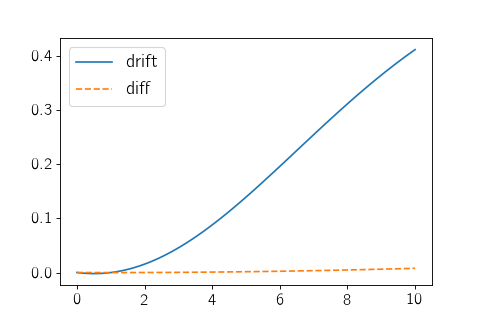

[      0.        701.824    1247.601    1636.441    1867.604    1940.495
    1854.671    1609.839    1205.858     642.739     -79.356    -960.11
   -1999.058   -3195.581   -4548.911   -6058.13    -7722.173   -9539.829
  -11509.742  -13630.414  -15900.209  -18317.354  -20879.939  -23585.928
  -26433.153  -29419.325  -32542.034  -35798.754  -39186.847  -42703.565
  -46346.059  -50111.381  -53996.487  -57998.244  -62113.437  -66338.769
  -70670.867  -75106.293  -79641.541  -84273.049  -88997.198  -93810.324
  -98708.718 -103688.633 -108746.29  -113877.883 -119079.582 -124347.543
 -129677.906 -135066.806 -140510.378 -146004.755 -151546.08  -157130.509
 -162754.212 -168413.382 -174104.234 -179823.016 -185566.005 -191329.519
 -197109.914 -202903.589 -208706.995 -214516.628 -220329.042 -226140.846
 -231948.708 -237749.358 -243539.591 -249316.267 -255076.316 -260816.737
 -266534.603 -272227.059 -277891.326 -283524.701 -289124.559 -294688.353
 -300213.616 -305697.959 -311139.077 -316534.743 -32

In [907]:
J = np.linspace(0,10,100)
atemp=1e-4
gtemp=0.02
dmu = atemp*(J-1)
plt.figure()
drift = lebDrift(J,gtemp,atemp)
diff  = lebDiff(dmu,gtemp)
plt.plot(J,drift,label='drift')
#plt.plot(J,drift**.5,label='drift^.5')
plt.plot(J,diff,'--',label='diff')
#plt.plot(J,diff*J,':',label='diff*J')
#plt.yscale('log')
plt.legend(loc=0)
print((diff-drift)*1e6)
print(drift*1e6)

In [199]:
# Boundary conditions
# def dirchlet(A,b,side,val):
#     if side==1: #Right side
#         b+=A[-1,:]*val
# def homNeumann()

def dirichlet(M,side):
    if side == 0:
        M[0,:]  = 0
    if side == 1:
        M[-1,:] = 0
    return M

def homNeumann(M1,M2,side):
    if side == 0:
        M1[0,:]=0
        M2[0,1] = 2*M2[0,1]
    elif side ==1:
        M1[-1,:]=0
        M2[-1,-2] = 2*M2[-1,-2]
    return M1,M2

In [132]:
Dnr = 4
plot_preDers(r,Dnr,Deq,Dibs,0)
# plot_preDers(r,Dnr,Deq,Dibs,1,psi)
# P = np.abs(dr*preDer1/(2*preDer2))
# plt.plot(r,P)
plt.grid(True)

plt.figure()
r=np.linspace(0,8,100)
J = 0.5*r**2
An = 4e-3 *1
JxDres=1
wJ_2 = np.sqrt(An*np.sqrt(JxDres)/a)/3
D0harm = JxDres**(-1/4)*An**(3/2)*a**(-1/2) *3/8    *11245
D = DD(r,1,Deq,Jxavg=1) + D0harm/ (1 + ((J-1)/wJ_2)**4)
D = DD(r,1,Deq,Jxavg=1) + D0harm* (1 - ((J-1)/wJ_2)**2)*((J-1)**2<wJ_2**2)
plt.plot(r,D)
print(wJ_2)

NameError: name 'r' is not defined

<IPython.core.display.Javascript object>


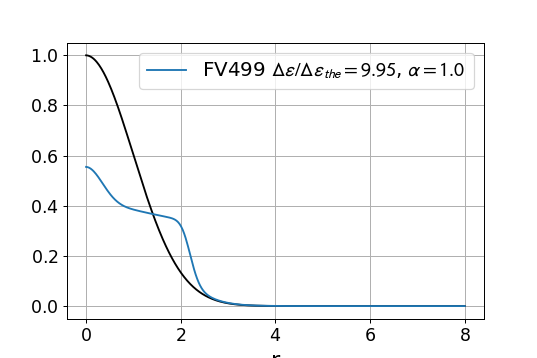

In [134]:
# Plotting
bool_plotOnce = 0
if not bool_plotOnce:
    plt.figure(6)
    plt.xlabel('r')
    plt.grid(True)

In [138]:
sq3 = np.sqrt(3)
pi = np.pi

bool_Dirichlet = 0
bool_timeDependentDiffCoeff = 0
bool_IncoNoise = 0
bool_conservative = 0
bool_smooth    = 0
bool_nopeak    = 0 # set derD[derD<0] = 0 -> still got a peak from below though... 
smoothFac      = 0.9999
iteration_scheme = 5 #[explicit euler, implicit euler, crank nicholson,...,odeint]
discretization_scheme = 2 #[0,FD, FV]
differentialEq = 3
alpha=1

bool_limitFV = 0
Dnr = 4 # [0,Constant, Lebedev ,...,action]
if differentialEq==4:
    Dnr=5

bool_smoothD = 0
bool_semiInco= 0
semiIncoFac = .2

Nr = 500
nturns = int(1e3) *.8
# nturns = 11 * 3.6 *1e6 *1 * 1e-5
noise = 1e-2 *sq3 
signoise=noise/sq3



#################################
### Initiate Space Separation ###
L = 8
if Dnr == 5:
    L = .5*L**2


r = np.linspace(0,L,Nr)
dr= np.diff(r)[0]
#temp for SD
Jb = 0.5*r**2
Jc = edge_to_center(Jb)
rb = r
rc = edge_to_center(rb)
if discretization_scheme == 2:
    # Finite volume
    Ne = Nr
    Nr = Ne-1
    rEdge = r
    r = edge_to_center(rEdge)
    

f_lhc = 11245 *1




Deq=1/4*signoise**2*f_lhc     # Coherent diffusion noise 
Dibs = Deq*0.01*bool_IncoNoise        # Incoherent diffusion noise: Intra beam scattering

lebfac=1
if g!=0 and Dnr!=1:
    lebfac = integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g))[0]

if bool_smoothD:
    Deq *= lebfac
    Dnr=1
elif bool_semiInco :
    Dibs = Deq*lebfac * semiIncoFac
    Deq *= (1-semiIncoFac)
    
D = Deq+Dibs
    
print('Deq ',Deq, Deq*lebfac)
print('Dibs',Dibs)
print('Expected emittance growth/h',2*D*3600, .5*signoise**2*f_lhc*3600,2*D*3600*lebfac)
emittexpect = .5*signoise**2*nturns
print('Expected emittance growth/1e5 turns',2*D/f_lhc*1e5, emittexpect,emittexpect*lebfac)


################################
#### Initiate time iteration ###
C = 1
dt = C*dr**2/Deq
# CFL = 1
# dt= CFL*dr/np.max(preDer1)
# print('CFL',np.max(preDer1)*dt/dr)
day1 = 24*3600
tmax = min(day1,15000*dt)  
tmaxODE =nturns/f_lhc #24*3600

# tmax = 24*3600
nt = max(int(np.ceil(tmax/dt)),3)
ts = np.linspace(0,tmax,nt)
tsode = np.linspace(0,tmaxODE,9)
dt = np.diff(ts)[0]
sig=1

tsODE = tsode
nt = np.size(tsODE)

print('dt  ',dt)
print('nt  ',nt)
print('tmax',tmax/3600)
print('tmaxODE',tmaxODE/3600)
print('1/(1+2Dt)',1/(1+2*(Deq+Dibs)*tmaxODE))

# Initial distribution
# if discretization_scheme==1:
psi0  =1/sig**2*np.exp(-0.5*r**2/sig**2)
if Dnr==5:
    psi0 = 1/sig*np.exp(-r/sig)
psis = np.zeros((nt,Nr))
psi = psi0
# elif discretization_scheme==2:
#     psi0FV=1/sig**2*np.exp(-0.5*r**2/sig**2)
#     psis = np.zeros((nt,Nc))
#     psi = psi0FV
    
psis[0,:]=psi

#################################
### Finish Space Separation ###
# Finite difference:
if discretization_scheme==1:
    upwind = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
    dnwind = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
    upwind2= ( 3*np.eye(Nr) -4*np.eye(Nr,k=-1)+np.eye(Nr,k=-2))/(2*dr)
    dnwind2= (-3*np.eye(Nr) +4*np.eye(Nr,k=1) -np.eye(Nr,k=2))/(2*dr)
    upwind2[:2,:2]  =upwind[:2,:2] ; dnwind2[-2:,-2:]=dnwind[-2:,-2:]
    centered=(np.eye(Nr,k=1)-np.eye(Nr,k=-1))/(2*dr)
    
    preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,0)[:2]
    vp = (preDer1<0)
    vm = (preDer1>0)


    # der1 = (upwind *vp + dnwind *vm)
    # der1 = (upwind2*vp + dnwind2*vm)
    der1= centered 
    # preDer1 = preDer1/S_Cummel(dr,preDer1,preDer2,2)
    # print(S_Cummel(dr,preDer1,preDer2,1))
    # print(preDer1.T)
    if np.any(preDer2==0):
        print("OBS: Zero diffusion")
        preDer2[preDer2==0]+=1e-9
    # print(S_Cummel(dr,preDer1,preDer2,1).T)
    preDer2 = preDer2*S_Cummel(dr,preDer1,preDer2,1)
    der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**2)




    # der1a = (np.eye(Nr) + np.eye(Nr,k= 1))/(2*dr)
    # der1b =-(np.eye(Nr) + np.eye(Nr,k=-1))/(2*dr)
    # A1 = der1a*(v[1:,np.newaxis]) + der1b*(v[:-1,np.newaxis])


    if 0:
        Jxavg=1
        redge = r[:-1]+np.diff(r)*0.5
        preDer1Edge = derDD(redge,Dnr,Deq,Jxavg) + DD(redge,Dnr,Deq,Dibs,Jxavg)/redge
        v = np.concatenate(([0],-preDer1Edge,[0]))
        vp = v>=0
        vn = v<0
        vvp=(v*vp)[np.newaxis,1:]
        vvm=(v*vn)[np.newaxis,:-1]
        vvp=(v*vp)[1:,np.newaxis]
        vvm=(v*vn)[:-1,np.newaxis]
        flux2 = -(upwind)*(vvp) \
                -(dnwind)*(vvm)
        A1 = flux2





    # A1 = preDer1*(preDer1>0)*upwind + preDer1*(preDer1<0)*dnwind


    A1 = preDer1*der1
    A2 = preDer2*der2
    homNeumann(A1,A2,0)
    homNeumann(A1,A2,1)
    homNeumann(der1,der2,0)
    homNeumann(der1,der2,1)
    
    # A = preDer1*der1 + preDer2*der2
    A = A1+ A2

elif discretization_scheme==2:
    if differentialEq ==1:
        # Finite volume
        der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
        der1R = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
        der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**1)

        coeffEdge=-rEdge*DD(rEdge,Dnr,Deq,Dibs)
#         print('test',coeffEdge*1e3)
    #     if not bool_Dirichlet: #Neumann
    #         coeffEdge[-1]=0
    #     elif bool_Dirichlet: #Dirichlet
    #         coeffEdge[-2]=0
        FVRe = -coeffEdge[1:,np.newaxis]*der1R
        FVLe = -coeffEdge[:-1,np.newaxis]*der1L

        FVD = 0
        if bool_limitFV:
            aa=coeffEdge[1:,np.newaxis]
            bb=coeffEdge[:-1,np.newaxis]
            P = (bb-aa)/(bb+aa)
            FVD = +(0.5*(aa+bb)*(S_Cummel_P(P)-1))*der2
    #         R = np.diff(psi0)[:-1]/np.diff(psi0)[1:]

        FV = (FVRe-FVLe +FVD)/ (dr*r[:,np.newaxis])  
        if Dnr==5:
            FV = (FVRe-FVLe +FVD)/ (dr)

        if not bool_Dirichlet: #Neumann
            print('None')
            FV[-1,-1]=-FV[-1,-2]
        if bool_Dirichlet: #Dirichlet
            FV[-1,:]=0

        print('TEST',coeffEdge.shape,der1L.shape)

    elif differentialEq ==2:
        # Finite volume
        der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
        der1R = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
        coeffEdge=rEdge
        FVRe = coeffEdge[1:,np.newaxis]*der1R
        FVLe = coeffEdge[:-1,np.newaxis]*der1L

        Javg = trapezoidal(rEdge,r*psi*r**2 / 2,discretization_scheme==2)
        print('Jxavg',Javg)
        FV = (FVRe-FVLe)/ (dr*r[:,np.newaxis]) *(DD(r,Dnr,Deq,Dibs,Jxavg=Javg))#[:,np.newaxis]

        if discretization_scheme == 5 : #
            print('Not implemented')
            
    elif differentialEq in [3,5]:
        # Matrices
        der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
        der1R = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
        avgL = ( np.eye(Nr) + np.eye(Nr,k=-1))/2
        avgR = ( np.eye(Nr) + np.eye(Nr,k=1))/2
        
        # Coefficients
        DEdge = DD(rEdge,Dnr,Deq,Dibs)
        derDEdge = (DD(rEdge+eps,Dnr,Deq,Dibs) - DD(rEdge-eps,Dnr,Deq,Dibs))/(2*eps)
        
        if bool_nopeak: derDEdge[derDEdge<0]=0
        
        coeffEdge=rEdge*DEdge
#         FV_diff =(coeffEdge[1:,np.newaxis]*der1R \
#                   coeffEdge[:-1,np.newaxis]*der1L) / (r*dr)
        
        
#         FV_drift
        
#         coeff0Diff0 = np.concatenate(([0],rEdge*DEdge,[0]))
        FV_diff = (np.diag((rEdge*DEdge)[1:-1],k=1)
                  -np.diag((rEdge*DEdge)[1:]+(rEdge*DEdge)[:-1],k=0)
                  +np.diag((rEdge*DEdge)[1:-1],k=-1)) /(r[:,np.newaxis]*dr**2)
        
        FV_drift =(np.diag((rEdge*derDEdge)[1:-1],k=1)
                  +np.diag((rEdge*derDEdge)[1:]-(rEdge*derDEdge)[:-1],k=0)
                  -np.diag((rEdge*derDEdge)[1:-1],k=-1)) /(2*r[:,np.newaxis]*dr) * (1-alpha)
        
        FV = FV_diff + FV_drift
        
        if differentialEq == 5:
            FV = FV_diff - .5*np.diag(.5*r*(DD(r+eps,Dnr,Deq,Dibs) - DD(r-eps,Dnr,Deq,Dibs))/(2*eps),k=0)
            
    elif differentialEq == 4:
        # 'r' = J 
        D0 = signoise**2/2 *f_lhc 
        dmu = pi2*a*(r-1) 
        
        Ddiff = D0*lebDiff(dmu,g)
        colcoeffDiff = r*Ddiff
        der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**2)
#         der2[0,0]=-der2[0,1]
        
        #dmuEdge =pi2*(a*rEdge-1)
        Ddrift = D0*lebDrift(r,g,a)
        colcoeffDrift = Ddrift
        der1 = (-np.eye(Nr,k=-1)+np.eye(Nr,k=1))/(2*dr**1)
#         der1[0,0] = der1[0,1]
        
        
         #[:,np.newaxis] #<- use this when rho_(t,i) depend on one value
        FV = der2*(colcoeffDiff) - der1*(colcoeffDrift)
        FV[0,1] = colcoeffDrift[1]/dr
        FV[0,0] = -FV[0,1]
        
        
        # If U=D
#         rP = rEdge[1:]
#         rM = rEdge[:-1]
#         der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr*rM
#         der1R = (-np.eye(Nr) +np.eye(Nr,k=1 ))/dr*rP
        
#         FV = der1L*(Ddrift[:,np.newaxis])
        
    
        
if bool_plotOnce:
    plt.figure(5)
    plt.xlabel('r')
else:
    plt.figure(6)


#############################
### Iteration preperation ###
if discretization_scheme==1:
    if bool_Dirichlet:
        A1 = dirichlet(A1,1)
        A2 = dirichlet(A2,1)
        A = A1+A2

    I    = np.eye(Nr)
    IE_A = I-dt*A
    CN_A = I-0.5*dt*(A1+A2)
    CN_B = I+0.5*dt*(A1+A2)

    # A1 = preDer1*der1
    limit = limiter(psi,dr,dt,Deq)
    S_A=I-0.5*dt*(A2+A1*limit)
    S_B=I+0.5*dt*(A2+A1*limit)

    
    def dpsidt(psi,t,r,A1=A1,A2=A2):
        if bool_timeDependentDiffCoeff:
            preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,True,psi)[:2]

            #Add numerical viscosity
            if np.any(preDer2==0):
                print("OBS: Zero diffusion")
                preDer2[preDer2==0]+=1e-9
            preDer2 = preDer2*S_Cummel(dr,preDer1,preDer2,1)

            A1 = preDer1*der1 ; A2 = preDer2*der2
            if bool_Dirichlet:
                A1 = dirichlet(A1,1)
                A2 = dirichlet(A2,1)
        return (A1+A2).dot(psi)
    
elif discretization_scheme == 2:
    if differentialEq==1:
        def dpsidtFV(psi,t,r,A=FV):
            if bool_timeDependentDiffCoeff:
                None
            return A.dot(psi)
    if differentialEq in [2,3,4,5]:
        # This is not physically relevant
        def dpsidtFV(psi,t,r,A=FV):
            # Javg = trapezoidal(rEdge,r*psi*r**2 / 2,discretization_scheme==2)
            #A = A*(DD(r,Dnr,Deq,Dibs,Jxavg=Javg)[:,np.newaxis])
            #psi[1:-1] = psi[1:-1]*smoothFac + .5*(1-smoothFac)*(psi[2:]+psi[:-2])
            return A.dot(psi)
    
        

        
#################
### Iteration ###        
if iteration_scheme!=5:
    for i,t in enumerate(ts):
        if i>0:
            # Update D,dD/dr,D/r
            if bool_timeDependentDiffCoeff:
                preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,True,psi)[:2]
                A1 = preDer1*der1 ; A2 = preDer2*der2
                if bool_Dirichlet:
                    A1 = dirichlet(A1,1)
                    A2 = dirichlet(A2,1)
                A = A1+A2

                I    = np.eye(Nr)
                IE_A = I-dt*A
                CN_A = I-0.5*dt*A
                CN_B = I+0.5*dt*A


            if iteration_scheme==1:
                psi += dt*A.dot(psi)
            elif iteration_scheme==2:
                psi = np.linalg.solve(IE_A , psi)
            elif iteration_scheme==3:
                psi = np.linalg.solve( CN_A,CN_B.dot(psi))

            elif iteration_scheme==4:
                limit = limiter(psi,dr,dt,Deq)
                S_A=I-0.5*dt*(A2+A1*limit)
                S_B=I+0.5*dt*(A2+A1*limit)
                psi = np.linalg.solve( S_A,S_B.dot(psi))

            if not bool_Dirichlet and bool_conservative:
                psi*=1/simp(r,r*psi)

        if bool_smooth:
            psi[1:-1] = psi[1:-1]*smoothFac + .5*(1-smoothFac)*(psi[2:]+psi[:-2])
        psis[i,:]=psi
        if i%10==0 :
            plt.plot(r,psi)

else:
    ts=tsode
    print('tsode',tsode)
    
    if discretization_scheme==1:
        psis = sc.integrate.odeint(dpsidt,psi0,tsode,args=(r,))
        psis1D=psis    
    elif discretization_scheme==2:
        psis = sc.integrate.odeint(dpsidtFV,psi0,tsode,args=(r,))
        psis1D=psis    
        
        
# Calculate emittance
if discretization_scheme==1:
    emittafter = simp(r,r*psis[-1,:] *r**2 / 2,discretization_scheme==2)
elif discretization_scheme==2:
    emittafter = trapezoidal(rEdge,r*psis[-1,:] *r**2 / 2,discretization_scheme==2)
if Dnr==5:
    emittafter = trapezoidal(rEdge,psis[-1,:] *r,discretization_scheme==2)
print('Emittance=%.4e | growth=%.2e | expgrowth=%.2e | ratio=%.3f'%(emittafter , emittafter-1, emittexpect*lebfac,(emittafter-1)/(emittexpect*lebfac)))

        
#Plotting
if iteration_scheme!=5:
    plt.plot(r,psi,label='t=%f'%tmax)
    D = DD(r,1,Deq,Dibs)*1
    psitheory = 1/(sig**2 + 2*D*tmax)*np.exp(-0.5*r**2/(sig**2 + 2*D*tmax))
    plt.plot(r,psitheory,':',lw=2)
else:
    x = r
    if Dnr==5:
        x= np.sqrt(2*r)
    print(x)
#    print(psis1D[-1,0:4],psis1D[-1,-4:])
    plt.plot(x,psis1D[0,:],'k')
    #plt.plot(r,psis1D[1,:],label=['FD','FV'][discretization_scheme-1]+str(Nr))
    plt.plot(x,psis1D[-1,:],label=['FD','FV'][discretization_scheme-1]+str(Nr)+
             ' $\Delta\epsilon/\Delta\epsilon_{the}=%.2f$'%((emittafter-1)/(emittexpect*lebfac))+
             ['',r', $\alpha=%.1f$'%alpha][differentialEq==3])
    plt.legend(loc=0)
#     plt.close(1)






# Testing
if discretization_scheme==1:
    None
#    print(preDer1[:15].T*1e6)
#    print(preDer2[:15].T*1e6)
    # print(der1x[:8,:8])
    # print(der2x[:8,:8])
elif discretization_scheme==2:
    None
#     print(rEdge)
    #print(coeffEdge * 1e4)
#     print(FV* 1e4)


# For stability diagram
# Get distribution in J as well
psisJ = psis
if bool_radial:
    psisJ = psisJ[:]*rc*np.diff(rb)/np.diff(Jb)
dPsis = np.diff(psisJ[:])/np.diff(Jc)

Deq  0.281125 0.281125
Dibs 0.0
Expected emittance growth/h 2024.1000000000001 2024.1000000000001 2024.1000000000001
Expected emittance growth/1e5 turns 5.0 0.04 0.04
dt   0.0009143413659177547
nt   9
tmax 0.003809501707611223
tmaxODE 1.976186947285213e-05
1/(1+2Dt) 0.9615384615384615
tsode [0.    0.009 0.018 0.027 0.036 0.044 0.053 0.062 0.071]
Emittance=1.3980e+00 | growth=3.98e-01 | expgrowth=4.00e-02 | ratio=9.950
[0.008 0.024 0.04  0.056 0.072 0.088 0.104 0.12  0.136 0.152 0.168 0.184
 0.2   0.216 0.232 0.248 0.265 0.281 0.297 0.313 0.329 0.345 0.361 0.377
 0.393 0.409 0.425 0.441 0.457 0.473 0.489 0.505 0.521 0.537 0.553 0.569
 0.585 0.601 0.617 0.633 0.649 0.665 0.681 0.697 0.713 0.729 0.745 0.762
 0.778 0.794 0.81  0.826 0.842 0.858 0.874 0.89  0.906 0.922 0.938 0.954
 0.97  0.986 1.002 1.018 1.034 1.05  1.066 1.082 1.098 1.114 1.13  1.146
 1.162 1.178 1.194 1.21  1.226 1.242 1.259 1.275 1.291 1.307 1.323 1.339
 1.355 1.371 1.387 1.403 1.419 1.435 1.451 1.467 1.483 1.499 1.515 

In [139]:
if 0 :
    print(FV*1e3)
    print(1e3*der2*(colcoeffDiff[:,np.newaxis]))
    print(-1e3*der1*(colcoeffDrift[:,np.newaxis]))
    # print(colcoeffDiff[:,np.newaxis]*1e6)
    # print(colcoeffDrift*1e6)

if 0:
    print(FV* 1e4)
    print(FV_drift*1e4)

    print(nt,Nr)
    
# 101: [ 0.626  0.626  0.626  0.626] [ 0.034  0.034  0.034  0.034]
# 201: [ 0.627  0.627  0.627  0.627] [ 0.032  0.032  0.032  0.032]
# 401: [ 0.629  0.629  0.629  0.629] [ 0.033  0.033  0.033  0.033]
# 801: [ 0.631  0.631  0.631  0.631] [ 0.032  0.032  0.032  0.032]

# 200: [ 0.61  0.61  0.61  0.61] [ 0.012  0.012  0.012  0.012]
# 400: [ 0.623  0.623  0.623  0.623] [ 0.012  0.012  0.012  0.012]
# 800: [ 0.628  0.628  0.628  0.628] [ 0.012  0.012  0.012  0.012]

nt=9 , nplots=100 -> plot_sep=1


<IPython.core.display.Javascript object>


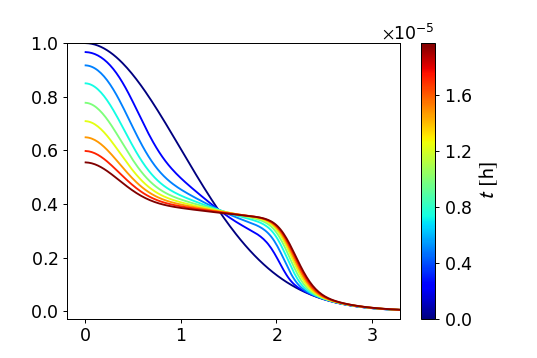

<IPython.core.display.Javascript object>


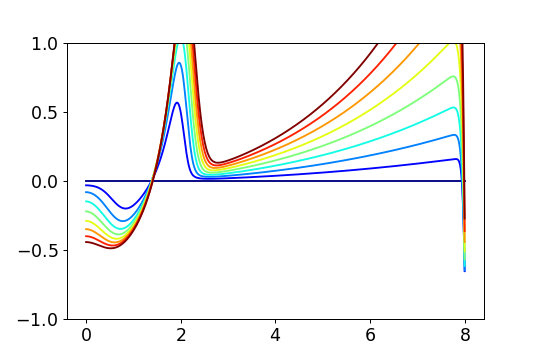

<IPython.core.display.Javascript object>


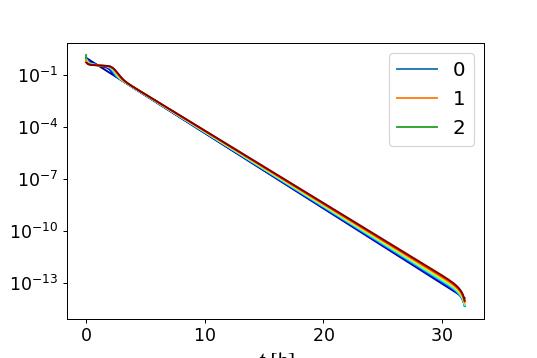

(9,) (9, 4)


<IPython.core.display.Javascript object>


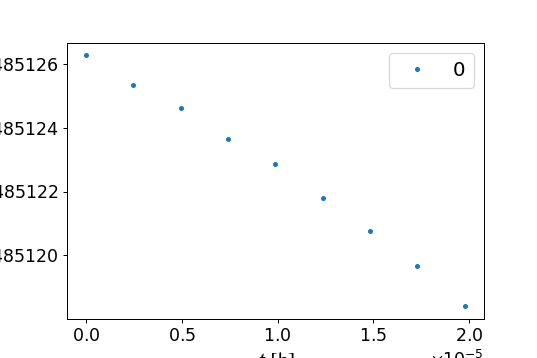

<IPython.core.display.Javascript object>


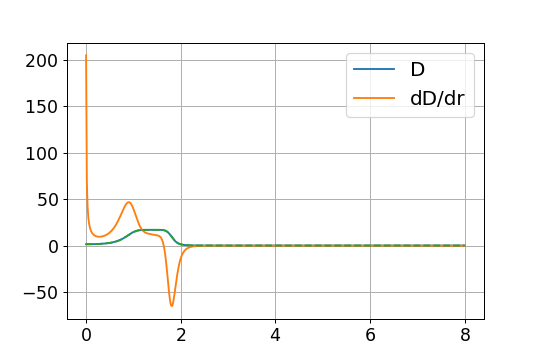

In [141]:
# psis=psis1D

# Plotting
time_scale = 1 ;  tlabel=r'$t$ $[\mathrm{sec}]$'
time_scale = 60 ; tlabel=r'$t$ $[\mathrm{min}]$'
time_scale = 3600 ; tlabel=r'$t$ $[\mathrm{h}]$'

nplots=100
plot_sep = int(np.ceil(np.size(ts)/nplots))
print('nt=%d , nplots=%d -> plot_sep=%d'%(nt,nplots,plot_sep))

fig1, ax1 = plt.subplots(dpi=100,num=10)
norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])


fig2 = plt.figure(num=11)
ax2 = plt.gca()

fig3, ax3 = plt.subplots(dpi=100,num=12)
norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
ax3.set_xlabel('J')
ax3.set_yscale('log')



moments = np.zeros((ts.size,4))
for i , t in enumerate(ts):
    if discretization_scheme==1:
        moments[i,:] = [simp(r,r*psis[i,:] *r**j / 2,discretization_scheme==2) for j in [0,1,2,3]]
    elif discretization_scheme==2:
        moments[i,:] = [trapezoidal(rEdge,r*psis[i,:] *r**j / 2,discretization_scheme==2) for j in [0,1,2,3]]
    if Dnr ==5:
        moments[i,:] = [trapezoidal(r,psis[i,:] *(r)**(j),0) for j in [0,1,2,3]]

    if i%plot_sep==0:
        ax1.plot(r,psis[i,:], c=cmap.to_rgba(t/time_scale))
        ax2.plot(r,(psis[i,:]-psis[0,:])/psis[0,:], c=cmap.to_rgba(t/time_scale))
        ax3.plot(Jc,psisJ[i,:], c=cmap.to_rgba(t/time_scale))
    
#         print(t/time_scale,np.sum(dr*r*psis[i,:]),np.sum(dr*r*r**2*psis[i,:]))

#ax1.set_yscale('log')

cb=fig1.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

# Theoretical curve
D = Deq+Dibs # DD(r,1,Deq)*1+Dibs
psitheory = 1/(sig**2 + 2*D*tmax)*np.exp(-0.5*r**2/(sig**2 + 2*D*tmax))
if 0:
    if Dnr==5:
        sigt=(sig**2+2*D*tmax)
        psiJtheory = 1/sigt*np.exp(-r/sigt)
        ax1.plot(r,psiJtheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
    else:
        ax1.plot(r,psitheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
    ax1.legend()

ax2.set_ylim([-1,1])

plt.figure(num=12)
print(ts.shape,moments.shape)
for i in range(3):
    
    plt.plot(ts/time_scale,moments[:,i],label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)

plt.figure(num=13)
for i in range(1):
    plt.plot(ts/time_scale,moments[:,i],'.',label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)


# Plot preders
if Dnr!=5:
    plot_preDers(r,Dnr,Deq,Dibs,1,psis[-1,:],fignradd=1)
# plot_preDers(r,Dnr,Deq,Dibs,1,psi)
plt.grid(True)

Good simulations:
    dx0.0_N1-5e-03_g2.0e-01_OPa1.0e-02_OPb0.0e+00_Qp0_Qs0.000_np1.0e+06_nt5e+05_dt2e+05
        Noise with damper. 
    dx0.0_N4-3e-03_g0.0e+00_OPa0.0e+00_OPb0.0e+00_Qp0_Qs0.000_np1.0e+06_nt1e+05_dt5e+04
        Gaussian noise. Clearly see buildup in the tail

In [301]:
ANoise=1e-4
frev = 11245
0.5*ANoise**2*frev*3600

0.20240999999999998

In [302]:
print(A1.shape,A2.shape)
print(A12D.shape,A22D.shape)
print(x.shape,y.shape,r.shape)
# print(A1*1e6)
# print(A2*1e6)
# print(A12D[:8,:8]*1e6)
# print(A22D[:8,:8]*1e6)
# print(psi0)
# print(psi02D.T)

print(psi0)
psi1 = sc.integrate.odeint(dpsidt,psi0,ts,args=(x,A1,A2))
print(psi02D.T[0,:Nx].shape)
psi2 = sc.integrate.odeint(dpsidt2D,psi02D.T[0,:Nx],ts,args=(x,y,A12D[:Nx,:Nx],A22D[:Nx,:Nx]))
psi3 = sc.integrate.odeint(dpsidt2D,psi02D.T[0],ts,args=(x,y,A12D,A22D))

print(ts)
print(psi1)
print(psi2)
print('ic',np.all(psi0==psi02D.T[0,:Nx]))
print(np.all(psi1==psi2))
print(psi3[:,:Nx])


A2D= A12D+A22D
A1D= A1 + A2
print(np.all(A2D[:Nx,:Nx]==A1D))

plt.figure()
plt.imshow(A12D+A22D,cmap='bwr')




NameError: name 'A1' is not defined

# test stuff in python 

In [303]:
a = np.arange(9).reshape(3,3)
b = np.arange(3)

print(a)
print(b)
print(a*b)
print(a*(b[:,np.newaxis]))

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[0 1 2]
[[ 0  1  4]
 [ 0  4 10]
 [ 0  7 16]]
[[ 0  0  0]
 [ 3  4  5]
 [12 14 16]]


## 2D diffusion

In [633]:
eps = 1e-5
ax = 1.64e-4
bx = -ax*190/260 * 1
ay=ax ; by=bx
# ay=by=0
g = 0.02
g2 = g/2
Qs = 0.002

QxIns = bx * 2 #JxQres
QyIns = by * 2

Jxavg = 1
Jyavg = 1

def fQx(Jx,Jy,a=ax,b=bx):
    return a*Jx + b*Jy
def fQy(Jx,Jy,a=ay,b=by):
    return b*Jx + a*Jy

def DD2D(x,y,Dnr,Deqx=1,Deqy=1,Jxavg = 1,Jyavg = 1):
    Dx = np.zeros_like(x)
    Dx[:] = np.nan
    Dy = np.zeros_like(x)
    Dy[:] = np.nan
    
    if Dnr == 1:
        D[:] = Deq
    elif Dnr == 2:
        
        dqx = ax * (0.5*x**2-Jxavg) + bx * (0.5*y**2-Jyavg)
        dqy = by * (0.5*x**2-Jxavg) + ay * (0.5*y**2-Jyavg)
        dmux = pi2*dqx
        dmuy = pi2*dqy
        c2 = (1-g2) 
        c3 = g2**2
        Dx[:] = Deq * c2**2*dmux**2 / (c3 + c2*dmux**2)
        Dy[:] = Deq * c2**2*dmuy**2 / (c3 + c2*dmuy**2)
    elif Dnr == 4:
        qx = ax * (0.5*x**2) + bx * (0.5*y**2)
        qy = by * (0.5*x**2) + ay * (0.5*y**2)
#         Qxavg = fQx(Jxavg,Jyavg)
#         Qyavg = fQy(Jxavg,Jyavg)
#         QxIns=Qxavg-Qs
#         QyIns=Qyavg-Qs
#         JxQres = 1
#         Jxavg  =3

        varQ2= 2*(0.4*max(ax,ay))**2

        Dx,Dy = DD2D(x,y,2,Deqx,Deqy,Jxavg,Jyavg)
#         Dx[:] *= (1+20*np.exp(-(qx-QxIns)**2/varQ2))
#         Dy[:] *= (1+20*np.exp(-(qy-QyIns)**2/varQ2))
        
        # Try resonance 
#         taux= tauy = 2/g
#         taux = 5/np.sqrt(2*ax**2 + 2*ax*bx + 2*bx**2)/pi2 
#         tauy = 5/np.sqrt(2*ay**2 + 2*ay*by + 2*by**2)/pi2
        j=3
        dj = np.sqrt(2*j)*.5*1e-4 # approximate value of change of J per kick
        taux = 1/np.sqrt(2*ax*dj) 
        tauy = 1/np.sqrt(2*ay*dj)
        Dx[:] *= (0 + 2/taux/(1/taux**2  + pi2**2*(qx-QxIns)**2) * 1e-0)
        Dy[:] *= (0 + 2/tauy/(1/tauy**2  + pi2**2*(qy-QyIns)**2) * 1e-0)
    
    else:
        print('This Diffusion coefficient is not implemented')
    return Dx,Dy

def derDD2D(x,y,Dnr,Deqx=1,Deqy=1,Jxavg = 1,Jyavg = 1):
    derDx = np.zeros_like(x)
    derDx[:] = np.nan
    derDy = np.zeros_like(x)
    derDy[:] = np.nan
    if Dnr == 1:
        derDx[:] = 0
        derDy[:] = 0
    elif Dnr == 2 :
        
        dqx = ax * (0.5*x**2-Jxavg) + bx * (0.5*y**2-Jyavg)
        dqy = by * (0.5*x**2-Jxavg) + ay * (0.5*y**2-Jyavg)
        dmux = pi2*dqx
        dmuy = pi2*dqy
        
        ddqxdx = ax * (x)
        ddqydy = ay * (y)
        
        ddmuxdx = pi2*ddqxdx
        ddmuydy = pi2*ddqydy
        
        c2 = (1-g2) 
        c3 = g2**2
        derDx[:] = Deq * c2**2 * c3 * 2*dmux/(c3 + c2*dmux**2)**2 * ddmuxdx
        derDy[:] = Deq * c2**2 * c3 * 2*dmuy/(c3 + c2*dmuy**2)**2 * ddmuydy
    elif Dnr==4:
        derDx[:] = (DD2D(x+eps,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)[0]-DD2D(x-eps,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)[0])/(2*eps)
        derDy[:] = (DD2D(x,y+eps,Dnr,Deqx,Deqy,Jxavg,Jyavg)[1]-DD2D(x,y-eps,Dnr,Deqx,Deqy,Jxavg,Jyavg)[1])/(2*eps)
    else:
        print('This Diffusion coefficient is not implemented')
    
    return derDx,derDy

def preDers2D(x,y,Dnr,Deqx,Deqy,Dibsx,Dibsy,bool_timeDependent=False,psi=0,Jxavg=Jxavg,Jyavg=Jyavg):
    
    if bool_timeDependent:
        print('Not ready for time dependent in 2D')
#         Jxavg = simp(r,0.5*r**2 *r*psi)
#         print('Avg Jx = %.2f'%Jxavg)
    
    preDer2x,preDer2y = DD2D(x,y,Dnr,Deqx,Deqy,Jxavg ,Jyavg )
    preDer2x += Dibsx   ;   preDer2y += Dibsy
    
    
    preDer1ax,preDer1ay = derDD2D(x,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)
#     if r[0]==0:
#         print(preDer2x.shape,x.shape)
#         preDer1bx = np.concatenate(([[0]],preDer2x[1:]/x[1:]))
#         preDer1by = np.concatenate(([[0]],preDer2y[1:]/y[1:]))
#     else:
    preDer1bx = preDer2x/x  ; preDer1bx[x==0] = 0
    preDer1by = preDer2y/y  ; preDer1by[y==0] = 0
    preDer1x = preDer1ax + preDer1bx
    preDer1y = preDer1ay + preDer1by
    
    
#     preDer1x = preDer1x[:,np.newaxis]  ; preDer2x = preDer2x[:,np.newaxis]  
#     preDer1y = preDer1y[:,np.newaxis]  ; preDer2y = preDer2y[:,np.newaxis]  
    return preDer1x, preDer2x,preDer1y, preDer2y

def trapezoidal2D(x,y,f):
    dx=x[1]-x[0]
    dy=y[1]-y[0]
    return dx*0.5*dy*0.5*(np.sum(f[1:,:]+f[:-1,:])+np.sum(f[:,1:]+f[:,:-1]))

def trapezoidal2Dproj(x,y,f):
    dy=y[1]-y[0]
    res=np.zeros_like(x)
    for i,ix in enumerate(x):
        res[i] = simp(y,y*f[:,i])
    return res

def trapezoidal(x,y,bool_center=0):
    if bool_center:
        dx = np.diff(x)[0]
        return np.sum(dx*y)
    else:
        return np.sum(np.diff(x)*(y[1:]+y[:-1]))*0.5

def simp(x,y,bool_center=0):
    if bool_center:
        print('CANNOT CALCULATE')
        return np.nan
    else:
        rest = (np.size(x)-1)%2
        dx = np.diff(x)[0]
        add=0
        if rest>0:
            print('N is even, simplify for last point')
            add = dx*0.5 * (y[-1]+y[-2])
            y = y[:-rest]

        return dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])+add

In [634]:
# taux= tauy = 2/g
print(taux,tauy)
taux = 1/np.sqrt(ax**2 + bx**2)/pi2 
tauy = 1/np.sqrt(2*ay**2 + 2*ay*by + 2*by**2)/pi2 
print(taux,tauy)

j=2
dj = np.sqrt(2*j)*.5*1e-4
taux = 1/np.sqrt(2*ax*dj) 
tauy = 1/np.sqrt(2*ay*dj)
print(taux,tauy)

NameError: name 'taux' is not defined

In [635]:
Dnr = 2
bool_timeDependent= False
bool_IncoNoise = 0
#################################
### Initiate Space Separation ###
Lx = 5
Ly = Lx
Nx = 31
Ny = Nx
N2 = Nx*Ny

x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
dx= np.diff(x)[0]
dy= np.diff(y)[0]

f_lhc = f_LHC= 11245
noise = 1e-4 * 100
Deq=0.5*noise**2*f_lhc # Coherent diffusion noise 
# Deq = 1
Deqx = Deq
Deqy = Deq

Dibsx= Dibsy = Deq*0.001*bool_IncoNoise        # Incoherent diffusion noise: Intra beam scattering


# upwind = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
# dnwind = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
# upwind2= ( 3*np.eye(Nr) -4*np.eye(Nr,k=-1)+np.eye(Nr,k=-2))/(2*dr)
# dnwind2= (-3*np.eye(Nr) +4*np.eye(Nr,k=1) -np.eye(Nr,k=2))/(2*dr)
# upwind2[:2,:2]  =upwind[:2,:2] ; dnwind2[-2:,-2:]=dnwind[-2:,-2:]
# centered=(np.eye(Nr,k=1)-np.eye(Nr,k=-1))/(2*dr)
# preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,0)[:2]
# vp = (preDer1<0)
# vm = (preDer1>0)

# der1 = (upwind2*vp + dnwind2*vm)
# der1= centered
der1xc = (np.eye(N2,k=1)-np.eye(N2,k=-1))/(2*dx)
der1yc = (np.eye(N2,k=Nx)-np.eye(N2,k=-Nx))/(2*dy)

der1x = der1xc
der1y = der1yc

der2x = (np.eye(N2,k=-1)+np.eye(N2,k=1)-2*np.eye(N2))/(dx**2)
der2y = (np.eye(N2,k=-Nx)+np.eye(N2,k=Nx)-2*np.eye(N2))/(dy**2)
        
#left reflective
der2x[0:N2:Nx,1:N2:Nx]*=2
der2x[Nx:N2:Nx,(Nx-1):N2:Nx]=0
der1x[0:N2:Nx,:]=0
#right reflective
der2x[(Nx-1):N2:Nx,(Nx-2):N2:Nx]*=2
der2x[(Nx-1):N2:Nx,(Nx-0):N2:Nx]=0
der1x[Nx-1:N2:Nx,:]=0
#bottom reflective
der2y[0:Nx:1,Nx:2*Nx:1]*=2
der1y[0:Nx,:]=0
#top reflective
der2y[N2-Nx:N2:1,N2-2*Nx:N2-Nx:1]*=2
der1y[N2-Nx:N2,:]=0    

# Coordinates and IC
X,Y= np.meshgrid(x,y)
xx = X.reshape((N2,1))
yy = Y.reshape((N2,1))
psi02D = np.exp(-0.5*xx**2-0.5*yy**2)
C = 1
dt = min(dx**2/Deqx,dy**2/Deqy)*C
Nt = 100
Nt = int(Nt/100)+1 ;  dt *= 100
ts = np.arange(Nt)*dt
Nt = 5
ts = np.linspace(0,1*3600,Nt)
ts = np.linspace(0,2e4/f_LHC,Nt)
# if g==0: ts=ts/100

preDer2x = np.ones((N2,1))*Deqx
preDer2y = np.ones((N2,1))*Deqy
preDer1x = preDer2x/xx ; preDer1x[np.isinf(preDer1x)]=0
preDer1y = preDer2y/yy ; preDer1y[np.isinf(preDer1y)]=0
preDer1x, preDer2x, preDer1y, preDer2y = preDers2D(xx,yy,Dnr,Deqx,Deqy,Dibsx,Dibsy,bool_timeDependent)

A12D = preDer1x*der1x + preDer1y*der1y
A22D = preDer2x*der2x + preDer2y*der2y

def dpsidt2D(psi,t,x=x,y=y,A1=A12D,A2=A22D):
    return (A1+A2).dot(psi)


print('Nx=%d , Ny=%d -> NxNy=%d'%(Nx,Ny,N2))
print('Nt',Nt)
print('dt',dt)
print('tmax [h]',np.max(ts)/3600)
print(X[0,2])
# print(preDer2y.T*1e6)
print(np.max(preDer1y)*1e9,np.max(preDer2y)*1e9)
print(preDer1x[:15].T*1e6)
print(preDer2x[:15].T*1e6)
print(der1x[:8,:8])
print(der2x[:8,:8])

Nx=31 , Ny=31 -> NxNy=961
Nt 5
dt 4.9404673682130325
tmax [h] 0.0004940467368213033
0.3333333333333333
1601555867.164844 340251259.70450073
[[    0.     1790.076   -31.643  -600.171  -347.332   803.186  3008.977
   6442.873 11269.396 17628.176 25617.482 35276.786 46569.323 59366.904
  73439.973]]
[[  423.805   381.236   267.022   121.694    12.93     35.589   311.43
    988.201  2237.701  4252.361  7239.896 11415.681 16992.644 24168.852
  33113.35 ]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-3.  0.  3.  0.  0.  0.  0.  0.]
 [ 0. -3.  0.  3.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  3.  0.  0.  0.]
 [ 0.  0.  0. -3.  0.  3.  0.  0.]
 [ 0.  0.  0.  0. -3.  0.  3.  0.]
 [ 0.  0.  0.  0.  0. -3.  0.  3.]
 [ 0.  0.  0.  0.  0.  0. -3.  0.]]
[[-72.  72.   0.   0.   0.   0.   0.   0.]
 [ 36. -72.  36.   0.   0.   0.   0.   0.]
 [  0.  36. -72.  36.   0.   0.   0.   0.]
 [  0.   0.  36. -72.  36.   0.   0.   0.]
 [  0.   0.   0.  36. -72.  36.   0.   0.]
 [  0.   0.   0.   0.  36. -72.  36.   0.]
 [  0.

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in true_divide


In [636]:
psis = sc.integrate.odeint(dpsidt2D,psi02D.T[0],ts,args=(x,y,))
psis2D=psis
print('Done')

Done


(961, 1) (961, 1) (961,)


<IPython.core.display.Javascript object>


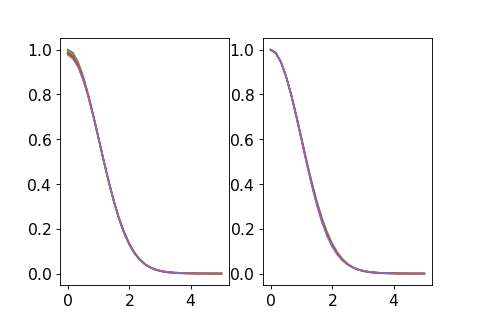

t=0.00: N=1.00, Jx=1.00, Jy=1.00
t=0.00: N=1.00, Jx=1.01, Jy=1.01
t=0.00: N=1.00, Jx=1.03, Jy=1.03
t=0.00: N=1.00, Jx=1.05, Jy=1.05
t=0.00: N=1.00, Jx=1.07, Jy=1.07
[ 0.     0.014  0.056  0.125  0.222  0.347  0.5    0.681  0.889  1.125
  1.389  1.681  2.     2.347  2.722  3.125  3.556  4.014  4.5    5.014
  5.556  6.125  6.722  7.347  8.     8.681  9.389 10.125 10.889 11.681
 12.5  ]


In [637]:
psis=psis2D
# print(simp(x,x*np.average(psis[0,:].reshape((Ny,Nx)),axis=0,weights=y)))
# print(simp(x,x*np.average(psis[-1,:].reshape((Ny,Nx)),axis=0,weights=y)))
print(xx.shape,yy.shape,psis[0,:].shape)
fig,axs=plt.subplots(1,2)

for i,t in enumerate(ts):
    norm = trapezoidal2D(x,y,X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    Jx   = trapezoidal2D(x,y,0.5*X**2*X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    Jy   = trapezoidal2D(x,y,0.5*Y**2*X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    print('t=%2.2f: N=%.2f, Jx=%.2f, Jy=%.2f'%(t/3600,norm,Jx,Jy))
    
    xproj=trapezoidal2Dproj(x,y,psis[i,:].reshape((Ny,Nx)))
    axs[0].plot(x,xproj)#psis[i,0*Nx:1*Nx])
    yproj=trapezoidal2Dproj(y,x,psis[i,:].reshape((Ny,Nx)).T)
    axs[1].plot(x,psis[i,:Nx]) #.reshape(Ny,Nx),axis=1)
#     axs[1].plot(y,yproj)
print(.5*x**2)


<IPython.core.display.Javascript object>


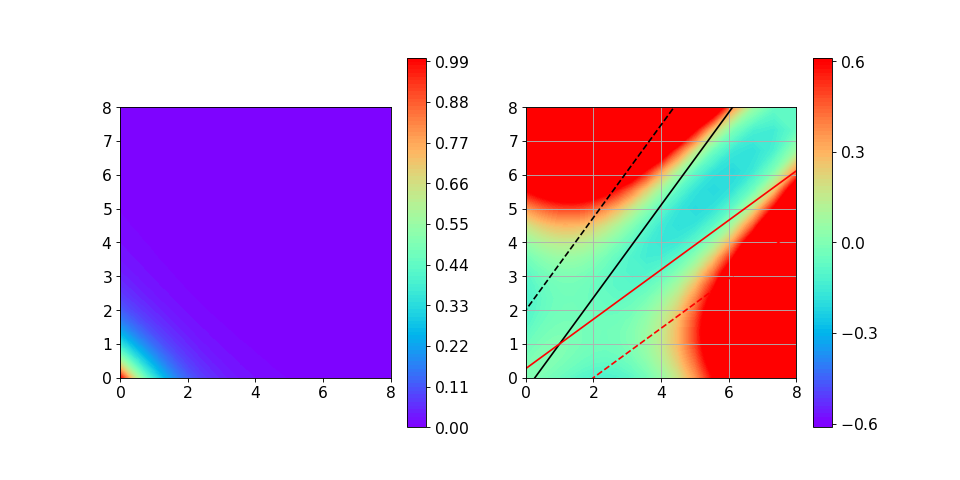

<IPython.core.display.Javascript object>


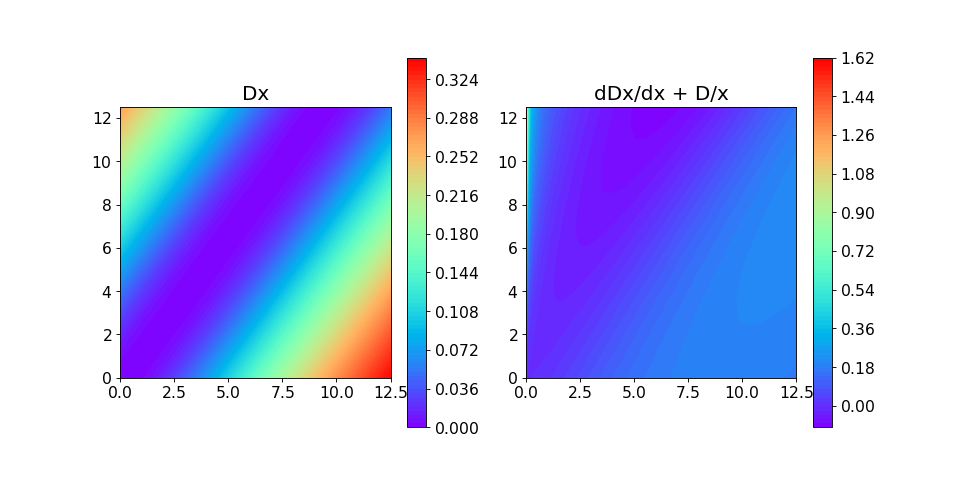

<IPython.core.display.Javascript object>


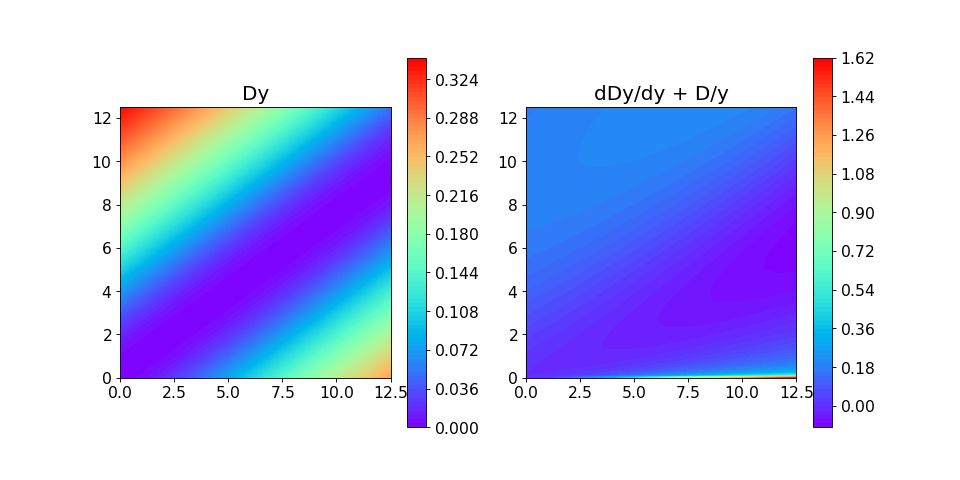

In [638]:
# Distribution

it = 4

fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,psis[it,:].reshape((Ny,Nx)),100,vmin=0,vmax=1)
plt.colorbar()
jmax=8
ax1.axis([0,jmax,0,jmax])

ax2= fig.add_subplot(122,aspect='equal')
# plt.contourf(.5*X**2,.5*Y**2,(psis[-1,:]-0*psis[0,:]).reshape((Nx,Ny)),100)
# plt.contourf(.5*X**2,.5*Y**2,((psis[-1,:]-psis[0,:])/psis[0,:]).reshape((Nx,Ny)),np.linspace(-0.1,.1,100))
change = ((psis[it,:]-psis[0,:])/psis[0,:])
maxchange = min(1,np.max(np.abs(change))/3) *3
maxchange = .6
levels = np.concatenate(([-1e9],np.linspace(-maxchange,maxchange,100),[1e9]))
cs=plt.contourf(.5*X**2,.5*Y**2,change.reshape((Ny,Nx)),levels,cmap=['seismic','jet','rainbow'][2])
cs.set_clim(-maxchange,maxchange)
ax2.axis([0,jmax,0,jmax])
ax2.grid(True)
cb=plt.colorbar(ticks=np.linspace(-maxchange,maxchange,5))
# cb.ticks()


for i in range(2):
    main = np.array([0,jmax])
    if [ax,ay][i]==0: continue
    
    if i==0:
        plt.plot(-1/ax*(bx*main-(ax*Jxavg+bx*Jyavg)),main,'k')
        plt.plot(-1/ax*(bx*main-QxIns),main,'k--')
    else:
        plt.plot(main,-1/ay*(by*main-(ay*Jyavg+by*Jxavg)),'r') #0 for y diff
        plt.plot(main,-1/ay*(by*main-QyIns),'r--')

# Coefficiencts in x diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer2x.reshape((Ny,Nx)),100)
plt.title('Dx')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer1x.reshape((Ny,Nx)),100)
plt.title('dDx/dx + D/x')
plt.colorbar()

# Coefficiencts in y diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer2y.reshape((Ny,Nx)),100)
plt.title('Dy')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer1y.reshape((Ny,Nx)),100)
plt.title('dDy/dy + D/y')
plt.colorbar()




In [309]:
# print(xx.reshape((Nx,Ny)),yy.T)
# print(preDer1x.T*1e6)
# print(preDer2x.T*1e9)
# print(psi0.T[0])
# print(der1x)
# print(der1y)
# print(der2x)
# print(der2y)

<IPython.core.display.Javascript object>


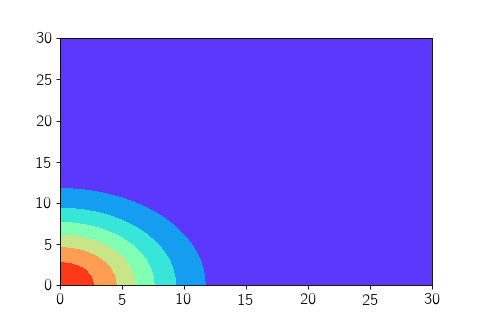

In [865]:
X,Y = np.meshgrid(x,y)
psi0 = np.exp(-0.5*X**2-0.5*Y**2)
plt.figure()
plt.contourf(psi0)

In [ ]:
# Interpolation

# Make a simple 2D interpolation
# obs: here it is FDM - only boundary values.

In [199]:
print(N2)

121


## Extra

<IPython.core.display.Javascript object>


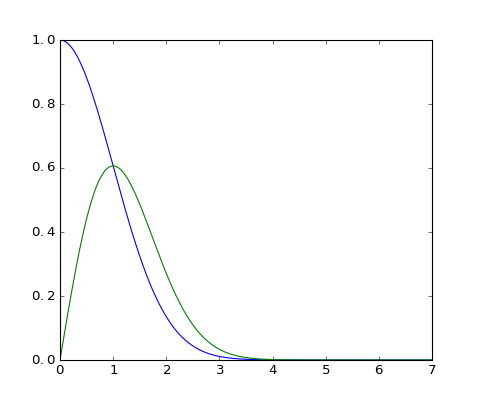

<IPython.core.display.Javascript object>


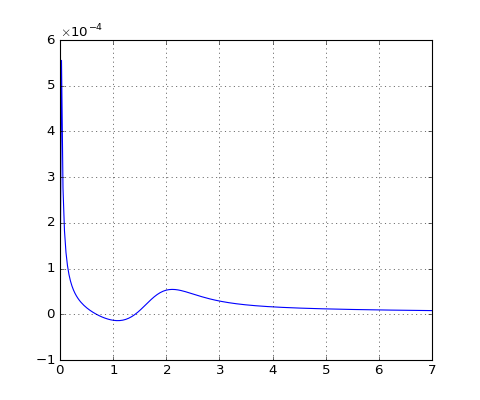

<IPython.core.display.Javascript object>


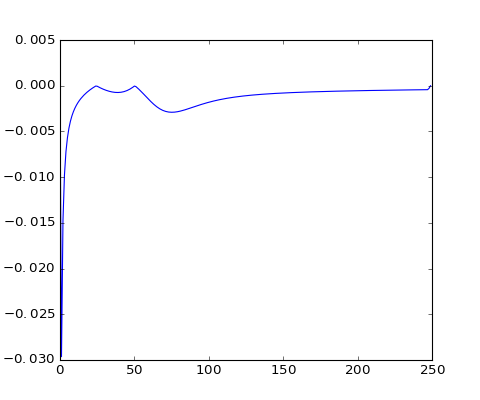

[1 2 3]
3


In [82]:
plt.figure()
plt.plot(r,psi)
plt.plot(r,r*psi)
plt.figure()
plt.plot(r,preDer1)
plt.grid(True)
plt.figure()
plt.plot(A1.diagonal())
# plt.plot(flux2.diagonal())
print(x)
print(x[-1])

In [782]:
Nr=5
Fm = np.eye(Nr,k=0)-np.eye(Nr,k=-1)
r= np.linspace(0,2,Nr)
redge = r[:-1]+np.diff(r)*0.5
Jxavg=1
preDer1Edge = derDD(redge,Dnr,Deq,Jxavg) + DD(redge,Dnr,Deq,Jxavg)/redge

print(Fm[1:]*preDer1Edge[:,np.newaxis])
print(u)
print(r,redge)
print(preDer1Edge)

[[-0.962  0.962  0.     0.     0.   ]
 [-0.     0.067 -0.067 -0.    -0.   ]
 [-0.    -0.     0.189 -0.189 -0.   ]
 [ 0.     0.     0.    -0.64   0.64 ]]
[ 2.    2.25  2.5   2.75  3.  ]
[ 0.   0.5  1.   1.5  2. ] [ 0.25  0.75  1.25  1.75]
[ 0.962 -0.067 -0.189  0.64 ]


In [99]:
if 0:
    # der1 = np.eye(Nr,k=0)-np.eye(Nr,k=-1)
    ve = np.arange(-2,2)
    ve = np.ones(Nr-1) #np.linspace(-2,2,Nr-1)
    v= np.concatenate(([0],ve,[0]))

    vp = v>0
    vn = v<0
    vvp=(v*vp)[np.newaxis,1:]
    vvm=(v*vn)[np.newaxis,:-1]
    upwind = np.eye(Nr) - np.eye(Nr,k=-1)
    dnwind = np.eye(Nr) - np.eye(Nr,k=1)
    flux2 = -(upwind)*(vvp) \
            +(dnwind)*(vvm)

    flux=  np.diag((v*vp)[1:-1],k=-1) - np.diag((v*vp)[1:],k=0) \
     - np.diag((v*vn)[1:-1],k= 1) + np.diag((v*vn)[:-1],k=0) 


    print(v)
    print(upwind)
    print(dnwind)
    print(flux)
    print(flux2)

In [208]:
n1=27
n2=33
print(r[n1])
print(der1[n1:n2,n1:n2])
print(dnwind[n1:n2,n1:n2])
print(upwind[n1:n2,n1:n2])
print(A1[n1:n2,n1:n2]*1e7)
print(preDer1Edge[n1:n2]*1e9)

1.26845637584
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  

In [792]:
aa = np.ones((3,3))
bb = np.arange(3)
print(aa*bb[:,np.newaxis])
print(aa*bb[np.newaxis,:])

[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]]
[[ 0.  1.  2.]
 [ 0.  1.  2.]
 [ 0.  1.  2.]]


<IPython.core.display.Javascript object>


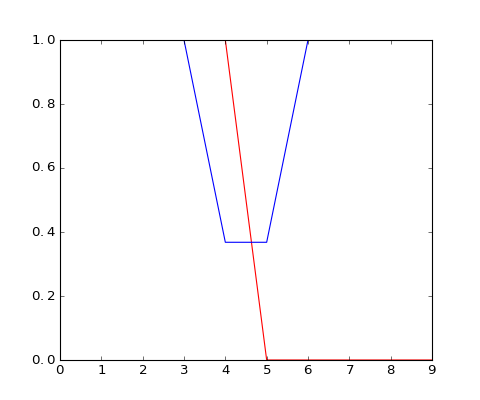

In [946]:


x = np.linspace(-4,4,15)
x = np.exp(-x**2)
x = np.ones(10)
x[5:] =0
plt.figure()
plt.plot(x,'r')
plt.plot(limiter(x))

In [227]:
a = np.arange(3)[:,np.newaxis]
# a = np.arange(3)
b = np.ones((3,3))
print(a.T)
print(b*a)

[[0 1 2]]
[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]]


## How to use odeint

In [277]:
Nr = 100
u = 1
def dydx(y,t,x):
    dx = np.diff(x)[0]
    A = (np.eye(Nr,k=1)+np.eye(Nr,k=-1)-2*np.eye(Nr))/dx**2
    return A.dot(y)

def dydx2(y,t,x):
    dx = np.diff(x)[0]
    A = -u*(np.eye(Nr,k=0)-np.eye(Nr,k=-1))/dx
    A[0,-1]=-A[0,0]
    
    return A.dot(y)

x = np.linspace(0,10,Nr)
y0 = np.exp(-(x-5)**2)

dt = 1*np.diff(x)[0]
t = np.arange(20)*dt

out = np.zeros((np.size(t),np.size(y0)))
for i,it in enumerate(t):
    if i==0: 
        out[i]=y0
    else:
        out[i] = out[i-1]+dt*dydx2(out[i-1],it,x)
    
# out=sc.integrate.odeint(dydx2,y0,t,args=(x,))

<IPython.core.display.Javascript object>


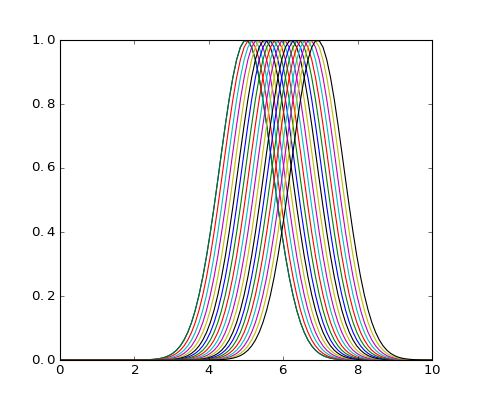

In [278]:
plt.figure()
plt.plot(x,y0)
plt.plot(x,out.T)

In [159]:
A= np.ones((4,4))*np.arange(4)
b = np.arange(4)

In [162]:
print(A*b)
print(A.dot(b))

[[ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]]
[ 14.  14.  14.  14.]


## Test integration

22.0 22.0 21.3333333333


<IPython.core.display.Javascript object>


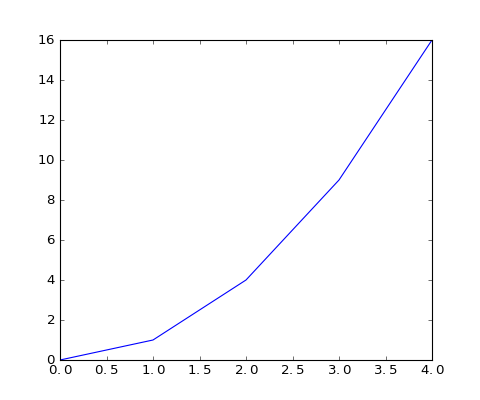

In [162]:
x = np.array([0,1,2,3,4])
y = np.array([0,1,4,9,16])


print(np.trapz(y,x),trapezoidal(x,y),simp(x,y))
plt.figure()
plt.plot(x,y)